In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as pyplot

from math import sqrt
from math import inf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

import tensorflow as tf

Using TensorFlow backend.


In [2]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [3]:
def aggregate_data(dataset):
    total_pop = sum(dataset["county_population"].unique())
    dataset["proportion"] = dataset["county_population"] / total_pop
    
    weighted_avg = pd.DataFrame()
    for date, date_data in dataset.groupby("date"):
        weighted_avg = weighted_avg.append(
            pd.DataFrame(date_data.iloc[:, 3:-3]
                .multiply(date_data["proportion"], axis=0)
                .sum(axis=0)).T, ignore_index=True)
        
    sum_data = dataset.groupby("date").agg("sum")[["cases", "deaths"]]
    data = pd.concat([sum_data, weighted_avg], axis=1)
    n_feats = len(data.columns)
    
    return data, n_feats

In [4]:
def split_data(values, days_predicted, train_prop=.8):
#     reframed = series_to_supervised(scaled_data, n_in=days_prior, n_out=days_predicted)
    
#     drop = [col for col in reframed.columns if '-' not in col and 'var1' not in col and 'var2' not in col]
#     reframed.drop(drop, axis=1, inplace=True)
#     values = reframed.values
    
    train_size = int(.8 * values.shape[0])
    train, test = values[:train_size, :], values[train_size:, :]
    X_train, y_train = train[:, :-2*days_predicted], train[:, -2*days_predicted:]
    X_test, y_test = test[:, :-2*days_predicted], test[:, -2*days_predicted:]
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    
    return X_train, y_train, X_test, y_test

In [113]:
def build_model(X_train, y_train, X_test, y_test, n_batch=1):
    model = Sequential()
    model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(128))
    model.add(Dense(y_train.shape[1])) # this might need to be changed
    model.compile(Adam(learning_rate=.00001), loss="mae")
    
    history = model.fit(X_train, y_train, epochs=100, 
                    batch_size=n_batch, validation_data=(X_test, y_test),
                    verbose=2, shuffle=False)

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    return model

In [114]:
def model_configs():
    n_in = [21, 14, 7, 5, 3]
    n_out = [1,2,3,7]
    n_batch = [1, 5, 10]
    
    configs = []
    for i in n_in:
        for j in n_out:
            for k in n_batch:
                        cfg = [i, j, k]
                        configs.append(cfg)
    total_configs = len(configs)
    print(total_configs)
    return configs
    

In [112]:
model_configs()

60


[[21, 1, 1],
 [21, 1, 5],
 [21, 1, 10],
 [21, 2, 1],
 [21, 2, 5],
 [21, 2, 10],
 [21, 3, 1],
 [21, 3, 5],
 [21, 3, 10],
 [21, 7, 1],
 [21, 7, 5],
 [21, 7, 10],
 [14, 1, 1],
 [14, 1, 5],
 [14, 1, 10],
 [14, 2, 1],
 [14, 2, 5],
 [14, 2, 10],
 [14, 3, 1],
 [14, 3, 5],
 [14, 3, 10],
 [14, 7, 1],
 [14, 7, 5],
 [14, 7, 10],
 [7, 1, 1],
 [7, 1, 5],
 [7, 1, 10],
 [7, 2, 1],
 [7, 2, 5],
 [7, 2, 10],
 [7, 3, 1],
 [7, 3, 5],
 [7, 3, 10],
 [7, 7, 1],
 [7, 7, 5],
 [7, 7, 10],
 [5, 1, 1],
 [5, 1, 5],
 [5, 1, 10],
 [5, 2, 1],
 [5, 2, 5],
 [5, 2, 10],
 [5, 3, 1],
 [5, 3, 5],
 [5, 3, 10],
 [5, 7, 1],
 [5, 7, 5],
 [5, 7, 10],
 [3, 1, 1],
 [3, 1, 5],
 [3, 1, 10],
 [3, 2, 1],
 [3, 2, 5],
 [3, 2, 10],
 [3, 3, 1],
 [3, 3, 5],
 [3, 3, 10],
 [3, 7, 1],
 [3, 7, 5],
 [3, 7, 10]]

In [66]:
def evaluate(model, X_test, y_test, n_feats, scaler):
    predictions = y_test.shape[1]
    yhat = model.predict(X_test)
    X_test_reshape = X_test.reshape(X_test.shape[0], X_test.shape[2])
    inv_yhat = np.concatenate((X_test_reshape[:, :], yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,-predictions:]
    y_test_reshaped = y_test.reshape((len(y_test), predictions))
    inv_y = np.concatenate((X_test_reshape[:, :], y_test_reshaped), axis=1)
    full = scaler.inverse_transform(inv_y)
    inv_y = full[:,-predictions:]
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    return inv_yhat, inv_y, rmse

60
Train on 67 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3637 - val_loss: 0.6957
Epoch 2/100
 - 0s - loss: 0.3207 - val_loss: 0.6276
Epoch 3/100
 - 0s - loss: 0.2955 - val_loss: 0.5732
Epoch 4/100
 - 0s - loss: 0.2709 - val_loss: 0.5165
Epoch 5/100
 - 0s - loss: 0.2499 - val_loss: 0.4638
Epoch 6/100
 - 0s - loss: 0.2304 - val_loss: 0.4165
Epoch 7/100
 - 0s - loss: 0.2114 - val_loss: 0.3687
Epoch 8/100
 - 0s - loss: 0.1960 - val_loss: 0.3353
Epoch 9/100
 - 0s - loss: 0.1795 - val_loss: 0.3111
Epoch 10/100
 - 0s - loss: 0.1647 - val_loss: 0.2955
Epoch 11/100
 - 0s - loss: 0.1515 - val_loss: 0.2788
Epoch 12/100
 - 0s - loss: 0.1402 - val_loss: 0.2608
Epoch 13/100
 - 0s - loss: 0.1312 - val_loss: 0.2339
Epoch 14/100
 - 0s - loss: 0.1228 - val_loss: 0.2090
Epoch 15/100
 - 0s - loss: 0.1158 - val_loss: 0.1947
Epoch 16/100
 - 0s - loss: 0.1106 - val_loss: 0.1889
Epoch 17/100
 - 0s - loss: 0.1062 - val_loss: 0.1758
Epoch 18/100
 - 0s - loss: 0.1022 - val_loss: 0.1624
Epoch 19

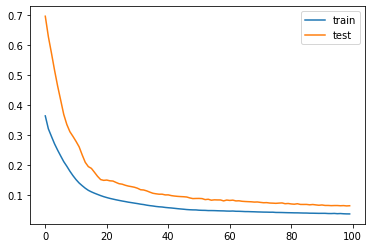

Train on 67 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3776 - val_loss: 0.7517
Epoch 2/100
 - 0s - loss: 0.3677 - val_loss: 0.7347
Epoch 3/100
 - 0s - loss: 0.3588 - val_loss: 0.7179
Epoch 4/100
 - 0s - loss: 0.3505 - val_loss: 0.7019
Epoch 5/100
 - 0s - loss: 0.3428 - val_loss: 0.6866
Epoch 6/100
 - 0s - loss: 0.3355 - val_loss: 0.6715
Epoch 7/100
 - 0s - loss: 0.3285 - val_loss: 0.6571
Epoch 8/100
 - 0s - loss: 0.3223 - val_loss: 0.6436
Epoch 9/100
 - 0s - loss: 0.3169 - val_loss: 0.6307
Epoch 10/100
 - 0s - loss: 0.3116 - val_loss: 0.6182
Epoch 11/100
 - 0s - loss: 0.3064 - val_loss: 0.6064
Epoch 12/100
 - 0s - loss: 0.3012 - val_loss: 0.5946
Epoch 13/100
 - 0s - loss: 0.2959 - val_loss: 0.5825
Epoch 14/100
 - 0s - loss: 0.2906 - val_loss: 0.5704
Epoch 15/100
 - 0s - loss: 0.2854 - val_loss: 0.5583
Epoch 16/100
 - 0s - loss: 0.2801 - val_loss: 0.5466
Epoch 17/100
 - 0s - loss: 0.2749 - val_loss: 0.5348
Epoch 18/100
 - 0s - loss: 0.2697 - val_loss: 0.5233
Epoch 19/10

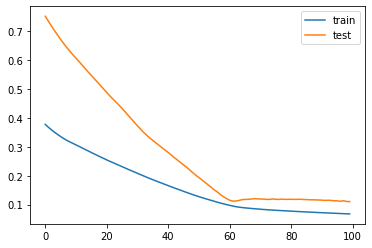

Train on 67 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3970 - val_loss: 0.7601
Epoch 2/100
 - 0s - loss: 0.3932 - val_loss: 0.7554
Epoch 3/100
 - 0s - loss: 0.3897 - val_loss: 0.7505
Epoch 4/100
 - 0s - loss: 0.3863 - val_loss: 0.7457
Epoch 5/100
 - 0s - loss: 0.3829 - val_loss: 0.7408
Epoch 6/100
 - 0s - loss: 0.3796 - val_loss: 0.7359
Epoch 7/100
 - 0s - loss: 0.3763 - val_loss: 0.7311
Epoch 8/100
 - 0s - loss: 0.3730 - val_loss: 0.7263
Epoch 9/100
 - 0s - loss: 0.3697 - val_loss: 0.7216
Epoch 10/100
 - 0s - loss: 0.3666 - val_loss: 0.7168
Epoch 11/100
 - 0s - loss: 0.3635 - val_loss: 0.7121
Epoch 12/100
 - 0s - loss: 0.3603 - val_loss: 0.7073
Epoch 13/100
 - 0s - loss: 0.3571 - val_loss: 0.7024
Epoch 14/100
 - 0s - loss: 0.3540 - val_loss: 0.6976
Epoch 15/100
 - 0s - loss: 0.3508 - val_loss: 0.6926
Epoch 16/100
 - 0s - loss: 0.3475 - val_loss: 0.6877
Epoch 17/100
 - 0s - loss: 0.3443 - val_loss: 0.6827
Epoch 18/100
 - 0s - loss: 0.3411 - val_loss: 0.6777
Epoch 19/10

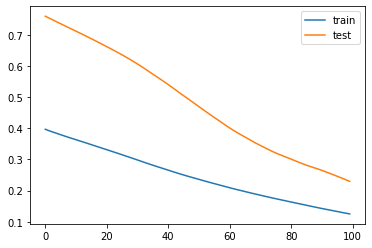

Train on 66 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3021 - val_loss: 0.8399
Epoch 2/100
 - 0s - loss: 0.2707 - val_loss: 0.7857
Epoch 3/100
 - 0s - loss: 0.2486 - val_loss: 0.7423
Epoch 4/100
 - 0s - loss: 0.2307 - val_loss: 0.6984
Epoch 5/100
 - 0s - loss: 0.2138 - val_loss: 0.6553
Epoch 6/100
 - 0s - loss: 0.1956 - val_loss: 0.6080
Epoch 7/100
 - 0s - loss: 0.1777 - val_loss: 0.5570
Epoch 8/100
 - 0s - loss: 0.1576 - val_loss: 0.4976
Epoch 9/100
 - 0s - loss: 0.1392 - val_loss: 0.4378
Epoch 10/100
 - 0s - loss: 0.1171 - val_loss: 0.3670
Epoch 11/100
 - 0s - loss: 0.0981 - val_loss: 0.2950
Epoch 12/100
 - 0s - loss: 0.0793 - val_loss: 0.2175
Epoch 13/100
 - 0s - loss: 0.0628 - val_loss: 0.1595
Epoch 14/100
 - 0s - loss: 0.0511 - val_loss: 0.1043
Epoch 15/100
 - 0s - loss: 0.0422 - val_loss: 0.0697
Epoch 16/100
 - 0s - loss: 0.0339 - val_loss: 0.0421
Epoch 17/100
 - 0s - loss: 0.0291 - val_loss: 0.0449
Epoch 18/100
 - 0s - loss: 0.0256 - val_loss: 0.0583
Epoch 19/10

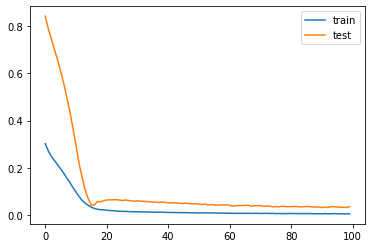

Train on 66 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.2826 - val_loss: 0.8220
Epoch 2/100
 - 0s - loss: 0.2750 - val_loss: 0.8099
Epoch 3/100
 - 0s - loss: 0.2684 - val_loss: 0.7975
Epoch 4/100
 - 0s - loss: 0.2622 - val_loss: 0.7850
Epoch 5/100
 - 0s - loss: 0.2569 - val_loss: 0.7728
Epoch 6/100
 - 0s - loss: 0.2523 - val_loss: 0.7612
Epoch 7/100
 - 0s - loss: 0.2479 - val_loss: 0.7496
Epoch 8/100
 - 0s - loss: 0.2437 - val_loss: 0.7380
Epoch 9/100
 - 0s - loss: 0.2394 - val_loss: 0.7262
Epoch 10/100
 - 0s - loss: 0.2352 - val_loss: 0.7146
Epoch 11/100
 - 0s - loss: 0.2310 - val_loss: 0.7030
Epoch 12/100
 - 0s - loss: 0.2267 - val_loss: 0.6913
Epoch 13/100
 - 0s - loss: 0.2223 - val_loss: 0.6793
Epoch 14/100
 - 0s - loss: 0.2178 - val_loss: 0.6670
Epoch 15/100
 - 0s - loss: 0.2133 - val_loss: 0.6544
Epoch 16/100
 - 0s - loss: 0.2087 - val_loss: 0.6415
Epoch 17/100
 - 0s - loss: 0.2040 - val_loss: 0.6281
Epoch 18/100
 - 0s - loss: 0.1992 - val_loss: 0.6142
Epoch 19/10

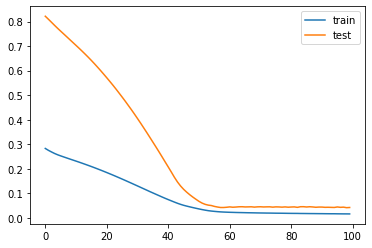

Train on 66 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.2855 - val_loss: 0.8709
Epoch 2/100
 - 0s - loss: 0.2814 - val_loss: 0.8642
Epoch 3/100
 - 0s - loss: 0.2778 - val_loss: 0.8576
Epoch 4/100
 - 0s - loss: 0.2744 - val_loss: 0.8509
Epoch 5/100
 - 0s - loss: 0.2711 - val_loss: 0.8444
Epoch 6/100
 - 0s - loss: 0.2681 - val_loss: 0.8382
Epoch 7/100
 - 0s - loss: 0.2652 - val_loss: 0.8322
Epoch 8/100
 - 0s - loss: 0.2625 - val_loss: 0.8264
Epoch 9/100
 - 0s - loss: 0.2600 - val_loss: 0.8208
Epoch 10/100
 - 0s - loss: 0.2574 - val_loss: 0.8153
Epoch 11/100
 - 0s - loss: 0.2549 - val_loss: 0.8099
Epoch 12/100
 - 0s - loss: 0.2524 - val_loss: 0.8044
Epoch 13/100
 - 0s - loss: 0.2499 - val_loss: 0.7989
Epoch 14/100
 - 0s - loss: 0.2475 - val_loss: 0.7933
Epoch 15/100
 - 0s - loss: 0.2450 - val_loss: 0.7878
Epoch 16/100
 - 0s - loss: 0.2425 - val_loss: 0.7822
Epoch 17/100
 - 0s - loss: 0.2401 - val_loss: 0.7766
Epoch 18/100
 - 0s - loss: 0.2376 - val_loss: 0.7710
Epoch 19/10

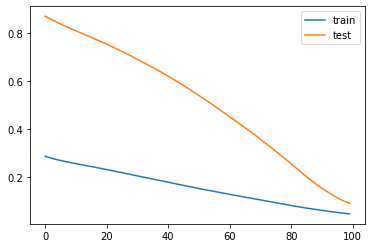

Train on 65 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3214 - val_loss: 0.8874
Epoch 2/100
 - 0s - loss: 0.2812 - val_loss: 0.8226
Epoch 3/100
 - 0s - loss: 0.2670 - val_loss: 0.7837
Epoch 4/100
 - 0s - loss: 0.2478 - val_loss: 0.7410
Epoch 5/100
 - 0s - loss: 0.2299 - val_loss: 0.6966
Epoch 6/100
 - 0s - loss: 0.2107 - val_loss: 0.6458
Epoch 7/100
 - 0s - loss: 0.1919 - val_loss: 0.5924
Epoch 8/100
 - 0s - loss: 0.1716 - val_loss: 0.5302
Epoch 9/100
 - 0s - loss: 0.1494 - val_loss: 0.4602
Epoch 10/100
 - 0s - loss: 0.1262 - val_loss: 0.3815
Epoch 11/100
 - 0s - loss: 0.1033 - val_loss: 0.2985
Epoch 12/100
 - 0s - loss: 0.0805 - val_loss: 0.2095
Epoch 13/100
 - 0s - loss: 0.0625 - val_loss: 0.1488
Epoch 14/100
 - 0s - loss: 0.0510 - val_loss: 0.1352
Epoch 15/100
 - 0s - loss: 0.0448 - val_loss: 0.1278
Epoch 16/100
 - 0s - loss: 0.0397 - val_loss: 0.1211
Epoch 17/100
 - 0s - loss: 0.0358 - val_loss: 0.1061
Epoch 18/100
 - 0s - loss: 0.0325 - val_loss: 0.0941
Epoch 19/10

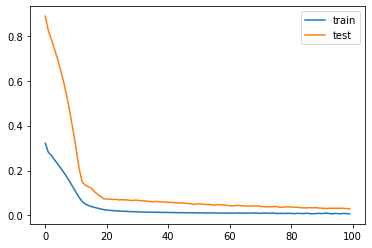

Train on 65 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.2756 - val_loss: 0.7410
Epoch 2/100
 - 0s - loss: 0.2673 - val_loss: 0.7292
Epoch 3/100
 - 0s - loss: 0.2597 - val_loss: 0.7175
Epoch 4/100
 - 0s - loss: 0.2523 - val_loss: 0.7058
Epoch 5/100
 - 0s - loss: 0.2449 - val_loss: 0.6941
Epoch 6/100
 - 0s - loss: 0.2376 - val_loss: 0.6824
Epoch 7/100
 - 0s - loss: 0.2302 - val_loss: 0.6707
Epoch 8/100
 - 0s - loss: 0.2233 - val_loss: 0.6593
Epoch 9/100
 - 0s - loss: 0.2171 - val_loss: 0.6484
Epoch 10/100
 - 0s - loss: 0.2116 - val_loss: 0.6384
Epoch 11/100
 - 0s - loss: 0.2064 - val_loss: 0.6287
Epoch 12/100
 - 0s - loss: 0.2012 - val_loss: 0.6191
Epoch 13/100
 - 0s - loss: 0.1959 - val_loss: 0.6092
Epoch 14/100
 - 0s - loss: 0.1906 - val_loss: 0.5991
Epoch 15/100
 - 0s - loss: 0.1853 - val_loss: 0.5884
Epoch 16/100
 - 0s - loss: 0.1801 - val_loss: 0.5773
Epoch 17/100
 - 0s - loss: 0.1753 - val_loss: 0.5661
Epoch 18/100
 - 0s - loss: 0.1706 - val_loss: 0.5542
Epoch 19/10

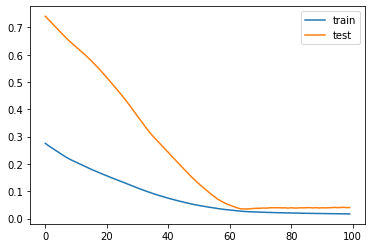

Train on 65 samples, validate on 17 samples
Epoch 1/100
 - 0s - loss: 0.2922 - val_loss: 0.8858
Epoch 2/100
 - 0s - loss: 0.2874 - val_loss: 0.8804
Epoch 3/100
 - 0s - loss: 0.2831 - val_loss: 0.8750
Epoch 4/100
 - 0s - loss: 0.2795 - val_loss: 0.8698
Epoch 5/100
 - 0s - loss: 0.2767 - val_loss: 0.8651
Epoch 6/100
 - 0s - loss: 0.2743 - val_loss: 0.8607
Epoch 7/100
 - 0s - loss: 0.2720 - val_loss: 0.8564
Epoch 8/100
 - 0s - loss: 0.2698 - val_loss: 0.8522
Epoch 9/100
 - 0s - loss: 0.2677 - val_loss: 0.8481
Epoch 10/100
 - 0s - loss: 0.2656 - val_loss: 0.8442
Epoch 11/100
 - 0s - loss: 0.2637 - val_loss: 0.8403
Epoch 12/100
 - 0s - loss: 0.2618 - val_loss: 0.8365
Epoch 13/100
 - 0s - loss: 0.2598 - val_loss: 0.8327
Epoch 14/100
 - 0s - loss: 0.2579 - val_loss: 0.8289
Epoch 15/100
 - 0s - loss: 0.2560 - val_loss: 0.8251
Epoch 16/100
 - 0s - loss: 0.2542 - val_loss: 0.8213
Epoch 17/100
 - 0s - loss: 0.2523 - val_loss: 0.8175
Epoch 18/100
 - 0s - loss: 0.2504 - val_loss: 0.8137
Epoch 19/10

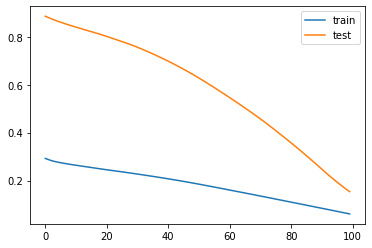

Train on 62 samples, validate on 16 samples
Epoch 1/100
 - 1s - loss: 0.3140 - val_loss: 0.8445
Epoch 2/100
 - 0s - loss: 0.2804 - val_loss: 0.7876
Epoch 3/100
 - 0s - loss: 0.2614 - val_loss: 0.7447
Epoch 4/100
 - 0s - loss: 0.2394 - val_loss: 0.6976
Epoch 5/100
 - 0s - loss: 0.2172 - val_loss: 0.6465
Epoch 6/100
 - 0s - loss: 0.1940 - val_loss: 0.5900
Epoch 7/100
 - 0s - loss: 0.1699 - val_loss: 0.5284
Epoch 8/100
 - 0s - loss: 0.1471 - val_loss: 0.4653
Epoch 9/100
 - 0s - loss: 0.1232 - val_loss: 0.3932
Epoch 10/100
 - 0s - loss: 0.1020 - val_loss: 0.3240
Epoch 11/100
 - 0s - loss: 0.0826 - val_loss: 0.2526
Epoch 12/100
 - 0s - loss: 0.0659 - val_loss: 0.1834
Epoch 13/100
 - 0s - loss: 0.0542 - val_loss: 0.1447
Epoch 14/100
 - 0s - loss: 0.0450 - val_loss: 0.0973
Epoch 15/100
 - 0s - loss: 0.0376 - val_loss: 0.0707
Epoch 16/100
 - 0s - loss: 0.0333 - val_loss: 0.0541
Epoch 17/100
 - 0s - loss: 0.0300 - val_loss: 0.0454
Epoch 18/100
 - 0s - loss: 0.0276 - val_loss: 0.0435
Epoch 19/10

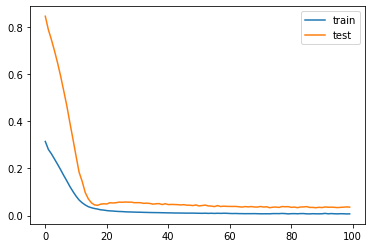

Train on 62 samples, validate on 16 samples
Epoch 1/100
 - 1s - loss: 0.3830 - val_loss: 0.9342
Epoch 2/100
 - 0s - loss: 0.3738 - val_loss: 0.9198
Epoch 3/100
 - 0s - loss: 0.3648 - val_loss: 0.9054
Epoch 4/100
 - 0s - loss: 0.3559 - val_loss: 0.8910
Epoch 5/100
 - 0s - loss: 0.3471 - val_loss: 0.8768
Epoch 6/100
 - 0s - loss: 0.3382 - val_loss: 0.8625
Epoch 7/100
 - 0s - loss: 0.3293 - val_loss: 0.8483
Epoch 8/100
 - 0s - loss: 0.3203 - val_loss: 0.8342
Epoch 9/100
 - 0s - loss: 0.3113 - val_loss: 0.8199
Epoch 10/100
 - 0s - loss: 0.3024 - val_loss: 0.8054
Epoch 11/100
 - 0s - loss: 0.2936 - val_loss: 0.7909
Epoch 12/100
 - 0s - loss: 0.2852 - val_loss: 0.7768
Epoch 13/100
 - 0s - loss: 0.2778 - val_loss: 0.7631
Epoch 14/100
 - 0s - loss: 0.2707 - val_loss: 0.7495
Epoch 15/100
 - 0s - loss: 0.2635 - val_loss: 0.7359
Epoch 16/100
 - 0s - loss: 0.2563 - val_loss: 0.7222
Epoch 17/100
 - 0s - loss: 0.2492 - val_loss: 0.7084
Epoch 18/100
 - 0s - loss: 0.2422 - val_loss: 0.6944
Epoch 19/10

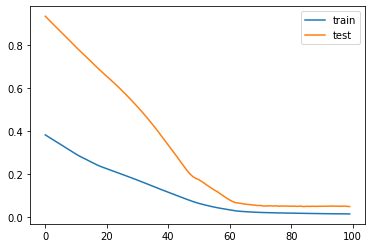

Train on 62 samples, validate on 16 samples
Epoch 1/100
 - 0s - loss: 0.3676 - val_loss: 0.9624
Epoch 2/100
 - 0s - loss: 0.3611 - val_loss: 0.9543
Epoch 3/100
 - 0s - loss: 0.3550 - val_loss: 0.9463
Epoch 4/100
 - 0s - loss: 0.3490 - val_loss: 0.9383
Epoch 5/100
 - 0s - loss: 0.3431 - val_loss: 0.9304
Epoch 6/100
 - 0s - loss: 0.3371 - val_loss: 0.9225
Epoch 7/100
 - 0s - loss: 0.3312 - val_loss: 0.9146
Epoch 8/100
 - 0s - loss: 0.3253 - val_loss: 0.9067
Epoch 9/100
 - 0s - loss: 0.3193 - val_loss: 0.8988
Epoch 10/100
 - 0s - loss: 0.3136 - val_loss: 0.8909
Epoch 11/100
 - 0s - loss: 0.3080 - val_loss: 0.8831
Epoch 12/100
 - 0s - loss: 0.3030 - val_loss: 0.8754
Epoch 13/100
 - 0s - loss: 0.2981 - val_loss: 0.8677
Epoch 14/100
 - 0s - loss: 0.2935 - val_loss: 0.8602
Epoch 15/100
 - 0s - loss: 0.2891 - val_loss: 0.8527
Epoch 16/100
 - 0s - loss: 0.2854 - val_loss: 0.8455
Epoch 17/100
 - 0s - loss: 0.2820 - val_loss: 0.8383
Epoch 18/100
 - 0s - loss: 0.2786 - val_loss: 0.8313
Epoch 19/10

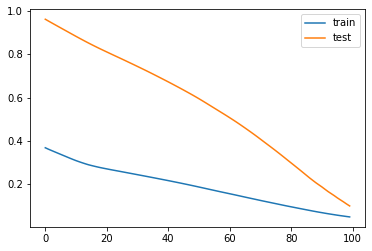

Train on 72 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.3446 - val_loss: 0.7001
Epoch 2/100
 - 0s - loss: 0.3212 - val_loss: 0.6517
Epoch 3/100
 - 0s - loss: 0.2985 - val_loss: 0.6024
Epoch 4/100
 - 0s - loss: 0.2775 - val_loss: 0.5531
Epoch 5/100
 - 0s - loss: 0.2569 - val_loss: 0.5010
Epoch 6/100
 - 0s - loss: 0.2374 - val_loss: 0.4471
Epoch 7/100
 - 0s - loss: 0.2192 - val_loss: 0.3979
Epoch 8/100
 - 0s - loss: 0.2021 - val_loss: 0.3553
Epoch 9/100
 - 0s - loss: 0.1871 - val_loss: 0.3169
Epoch 10/100
 - 0s - loss: 0.1739 - val_loss: 0.2884
Epoch 11/100
 - 0s - loss: 0.1620 - val_loss: 0.2669
Epoch 12/100
 - 0s - loss: 0.1506 - val_loss: 0.2539
Epoch 13/100
 - 0s - loss: 0.1402 - val_loss: 0.2426
Epoch 14/100
 - 0s - loss: 0.1322 - val_loss: 0.2250
Epoch 15/100
 - 0s - loss: 0.1257 - val_loss: 0.2101
Epoch 16/100
 - 0s - loss: 0.1201 - val_loss: 0.1952
Epoch 17/100
 - 0s - loss: 0.1152 - val_loss: 0.1861
Epoch 18/100
 - 0s - loss: 0.1102 - val_loss: 0.1801
Epoch 19/10

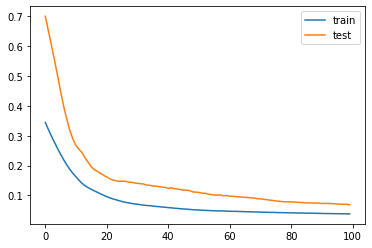

Train on 72 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.3607 - val_loss: 0.7873
Epoch 2/100
 - 0s - loss: 0.3531 - val_loss: 0.7773
Epoch 3/100
 - 0s - loss: 0.3464 - val_loss: 0.7674
Epoch 4/100
 - 0s - loss: 0.3403 - val_loss: 0.7578
Epoch 5/100
 - 0s - loss: 0.3345 - val_loss: 0.7483
Epoch 6/100
 - 0s - loss: 0.3287 - val_loss: 0.7387
Epoch 7/100
 - 0s - loss: 0.3231 - val_loss: 0.7291
Epoch 8/100
 - 0s - loss: 0.3176 - val_loss: 0.7195
Epoch 9/100
 - 0s - loss: 0.3122 - val_loss: 0.7098
Epoch 10/100
 - 0s - loss: 0.3068 - val_loss: 0.6998
Epoch 11/100
 - 0s - loss: 0.3014 - val_loss: 0.6896
Epoch 12/100
 - 0s - loss: 0.2959 - val_loss: 0.6791
Epoch 13/100
 - 0s - loss: 0.2905 - val_loss: 0.6686
Epoch 14/100
 - 0s - loss: 0.2850 - val_loss: 0.6579
Epoch 15/100
 - 0s - loss: 0.2797 - val_loss: 0.6472
Epoch 16/100
 - 0s - loss: 0.2745 - val_loss: 0.6362
Epoch 17/100
 - 0s - loss: 0.2696 - val_loss: 0.6253
Epoch 18/100
 - 0s - loss: 0.2648 - val_loss: 0.6142
Epoch 19/10

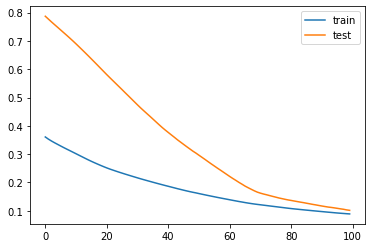

Train on 72 samples, validate on 19 samples
Epoch 1/100
 - 0s - loss: 0.3827 - val_loss: 0.7516
Epoch 2/100
 - 0s - loss: 0.3791 - val_loss: 0.7463
Epoch 3/100
 - 0s - loss: 0.3758 - val_loss: 0.7408
Epoch 4/100
 - 0s - loss: 0.3727 - val_loss: 0.7355
Epoch 5/100
 - 0s - loss: 0.3696 - val_loss: 0.7302
Epoch 6/100
 - 0s - loss: 0.3666 - val_loss: 0.7250
Epoch 7/100
 - 0s - loss: 0.3637 - val_loss: 0.7198
Epoch 8/100
 - 0s - loss: 0.3609 - val_loss: 0.7148
Epoch 9/100
 - 0s - loss: 0.3581 - val_loss: 0.7099
Epoch 10/100
 - 0s - loss: 0.3553 - val_loss: 0.7050
Epoch 11/100
 - 0s - loss: 0.3525 - val_loss: 0.7001
Epoch 12/100
 - 0s - loss: 0.3498 - val_loss: 0.6953
Epoch 13/100
 - 0s - loss: 0.3470 - val_loss: 0.6904
Epoch 14/100
 - 0s - loss: 0.3443 - val_loss: 0.6855
Epoch 15/100
 - 0s - loss: 0.3415 - val_loss: 0.6806
Epoch 16/100
 - 0s - loss: 0.3387 - val_loss: 0.6758
Epoch 17/100
 - 0s - loss: 0.3360 - val_loss: 0.6708
Epoch 18/100
 - 0s - loss: 0.3332 - val_loss: 0.6659
Epoch 19/10

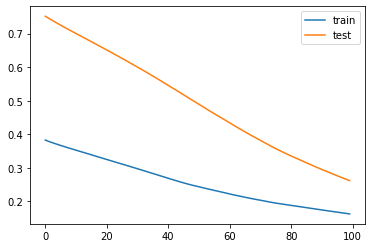

Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2618 - val_loss: 0.8521
Epoch 2/100
 - 0s - loss: 0.2317 - val_loss: 0.8051
Epoch 3/100
 - 0s - loss: 0.2135 - val_loss: 0.7723
Epoch 4/100
 - 0s - loss: 0.1995 - val_loss: 0.7394
Epoch 5/100
 - 0s - loss: 0.1887 - val_loss: 0.7086
Epoch 6/100
 - 0s - loss: 0.1775 - val_loss: 0.6753
Epoch 7/100
 - 0s - loss: 0.1670 - val_loss: 0.6394
Epoch 8/100
 - 0s - loss: 0.1568 - val_loss: 0.6009
Epoch 9/100
 - 0s - loss: 0.1461 - val_loss: 0.5605
Epoch 10/100
 - 0s - loss: 0.1361 - val_loss: 0.5182
Epoch 11/100
 - 0s - loss: 0.1259 - val_loss: 0.4746
Epoch 12/100
 - 0s - loss: 0.1159 - val_loss: 0.4284
Epoch 13/100
 - 0s - loss: 0.1059 - val_loss: 0.3828
Epoch 14/100
 - 0s - loss: 0.0957 - val_loss: 0.3308
Epoch 15/100
 - 0s - loss: 0.0861 - val_loss: 0.2826
Epoch 16/100
 - 0s - loss: 0.0759 - val_loss: 0.2258
Epoch 17/100
 - 0s - loss: 0.0664 - val_loss: 0.1735
Epoch 18/100
 - 0s - loss: 0.0588 - val_loss: 0.1272
Epoch 19/10

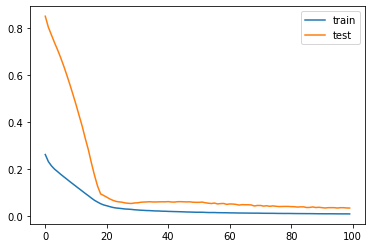

Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2755 - val_loss: 0.8826
Epoch 2/100
 - 0s - loss: 0.2689 - val_loss: 0.8753
Epoch 3/100
 - 0s - loss: 0.2631 - val_loss: 0.8680
Epoch 4/100
 - 0s - loss: 0.2574 - val_loss: 0.8608
Epoch 5/100
 - 0s - loss: 0.2517 - val_loss: 0.8536
Epoch 6/100
 - 0s - loss: 0.2459 - val_loss: 0.8464
Epoch 7/100
 - 0s - loss: 0.2401 - val_loss: 0.8391
Epoch 8/100
 - 0s - loss: 0.2346 - val_loss: 0.8320
Epoch 9/100
 - 0s - loss: 0.2299 - val_loss: 0.8255
Epoch 10/100
 - 0s - loss: 0.2266 - val_loss: 0.8197
Epoch 11/100
 - 0s - loss: 0.2236 - val_loss: 0.8140
Epoch 12/100
 - 0s - loss: 0.2206 - val_loss: 0.8083
Epoch 13/100
 - 0s - loss: 0.2176 - val_loss: 0.8024
Epoch 14/100
 - 0s - loss: 0.2147 - val_loss: 0.7966
Epoch 15/100
 - 0s - loss: 0.2119 - val_loss: 0.7908
Epoch 16/100
 - 0s - loss: 0.2090 - val_loss: 0.7848
Epoch 17/100
 - 0s - loss: 0.2062 - val_loss: 0.7786
Epoch 18/100
 - 0s - loss: 0.2036 - val_loss: 0.7722
Epoch 19/10

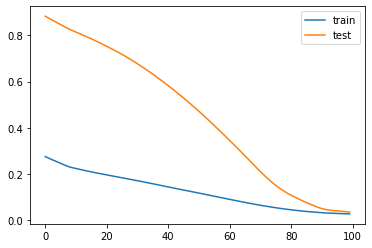

Train on 72 samples, validate on 18 samples
Epoch 1/100
 - 0s - loss: 0.2929 - val_loss: 0.8925
Epoch 2/100
 - 0s - loss: 0.2897 - val_loss: 0.8886
Epoch 3/100
 - 0s - loss: 0.2871 - val_loss: 0.8845
Epoch 4/100
 - 0s - loss: 0.2848 - val_loss: 0.8805
Epoch 5/100
 - 0s - loss: 0.2825 - val_loss: 0.8766
Epoch 6/100
 - 0s - loss: 0.2803 - val_loss: 0.8729
Epoch 7/100
 - 0s - loss: 0.2783 - val_loss: 0.8693
Epoch 8/100
 - 0s - loss: 0.2762 - val_loss: 0.8658
Epoch 9/100
 - 0s - loss: 0.2741 - val_loss: 0.8624
Epoch 10/100
 - 0s - loss: 0.2721 - val_loss: 0.8590
Epoch 11/100
 - 0s - loss: 0.2701 - val_loss: 0.8556
Epoch 12/100
 - 0s - loss: 0.2680 - val_loss: 0.8522
Epoch 13/100
 - 0s - loss: 0.2660 - val_loss: 0.8488
Epoch 14/100
 - 0s - loss: 0.2639 - val_loss: 0.8453
Epoch 15/100
 - 0s - loss: 0.2619 - val_loss: 0.8418
Epoch 16/100
 - 0s - loss: 0.2599 - val_loss: 0.8384
Epoch 17/100
 - 0s - loss: 0.2579 - val_loss: 0.8349
Epoch 18/100
 - 0s - loss: 0.2558 - val_loss: 0.8315
Epoch 19/10

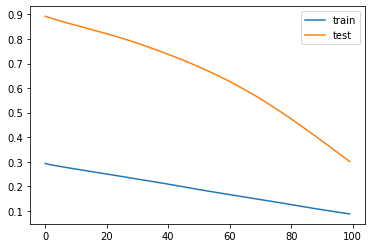

Train on 71 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2960 - val_loss: 0.8683
Epoch 2/100
 - 0s - loss: 0.2616 - val_loss: 0.8083
Epoch 3/100
 - 0s - loss: 0.2306 - val_loss: 0.7551
Epoch 4/100
 - 0s - loss: 0.2109 - val_loss: 0.7192
Epoch 5/100
 - 0s - loss: 0.1954 - val_loss: 0.6816
Epoch 6/100
 - 0s - loss: 0.1808 - val_loss: 0.6418
Epoch 7/100
 - 0s - loss: 0.1660 - val_loss: 0.5989
Epoch 8/100
 - 0s - loss: 0.1527 - val_loss: 0.5561
Epoch 9/100
 - 0s - loss: 0.1384 - val_loss: 0.5084
Epoch 10/100
 - 0s - loss: 0.1253 - val_loss: 0.4589
Epoch 11/100
 - 0s - loss: 0.1127 - val_loss: 0.4101
Epoch 12/100
 - 0s - loss: 0.1004 - val_loss: 0.3556
Epoch 13/100
 - 0s - loss: 0.0883 - val_loss: 0.3039
Epoch 14/100
 - 0s - loss: 0.0775 - val_loss: 0.2484
Epoch 15/100
 - 0s - loss: 0.0672 - val_loss: 0.2005
Epoch 16/100
 - 0s - loss: 0.0595 - val_loss: 0.1579
Epoch 17/100
 - 0s - loss: 0.0517 - val_loss: 0.1235
Epoch 18/100
 - 0s - loss: 0.0446 - val_loss: 0.0990
Epoch 19/10

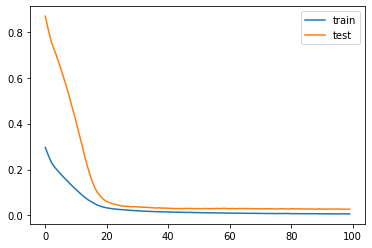

Train on 71 samples, validate on 18 samples
Epoch 1/100
 - 1s - loss: 0.2850 - val_loss: 0.8779
Epoch 2/100
 - 0s - loss: 0.2778 - val_loss: 0.8693
Epoch 3/100
 - 0s - loss: 0.2712 - val_loss: 0.8607
Epoch 4/100
 - 0s - loss: 0.2646 - val_loss: 0.8521
Epoch 5/100
 - 0s - loss: 0.2581 - val_loss: 0.8435
Epoch 6/100
 - 0s - loss: 0.2515 - val_loss: 0.8349
Epoch 7/100
 - 0s - loss: 0.2450 - val_loss: 0.8263
Epoch 8/100
 - 0s - loss: 0.2395 - val_loss: 0.8182
Epoch 9/100
 - 0s - loss: 0.2344 - val_loss: 0.8106
Epoch 10/100
 - 0s - loss: 0.2305 - val_loss: 0.8041
Epoch 11/100
 - 0s - loss: 0.2272 - val_loss: 0.7978
Epoch 12/100
 - 0s - loss: 0.2240 - val_loss: 0.7915
Epoch 13/100
 - 0s - loss: 0.2206 - val_loss: 0.7852
Epoch 14/100
 - 0s - loss: 0.2173 - val_loss: 0.7787
Epoch 15/100
 - 0s - loss: 0.2140 - val_loss: 0.7721
Epoch 16/100
 - 0s - loss: 0.2107 - val_loss: 0.7654
Epoch 17/100
 - 0s - loss: 0.2073 - val_loss: 0.7584
Epoch 18/100
 - 0s - loss: 0.2039 - val_loss: 0.7513
Epoch 19/10

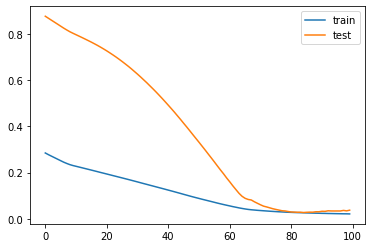

Train on 71 samples, validate on 18 samples
Epoch 1/100
 - 0s - loss: 0.2601 - val_loss: 0.8397
Epoch 2/100
 - 0s - loss: 0.2566 - val_loss: 0.8352
Epoch 3/100
 - 0s - loss: 0.2537 - val_loss: 0.8307
Epoch 4/100
 - 0s - loss: 0.2508 - val_loss: 0.8262
Epoch 5/100
 - 0s - loss: 0.2480 - val_loss: 0.8217
Epoch 6/100
 - 0s - loss: 0.2452 - val_loss: 0.8172
Epoch 7/100
 - 0s - loss: 0.2428 - val_loss: 0.8129
Epoch 8/100
 - 0s - loss: 0.2406 - val_loss: 0.8087
Epoch 9/100
 - 0s - loss: 0.2388 - val_loss: 0.8047
Epoch 10/100
 - 0s - loss: 0.2373 - val_loss: 0.8010
Epoch 11/100
 - 0s - loss: 0.2358 - val_loss: 0.7973
Epoch 12/100
 - 0s - loss: 0.2343 - val_loss: 0.7936
Epoch 13/100
 - 0s - loss: 0.2328 - val_loss: 0.7900
Epoch 14/100
 - 0s - loss: 0.2313 - val_loss: 0.7864
Epoch 15/100
 - 0s - loss: 0.2298 - val_loss: 0.7828
Epoch 16/100
 - 0s - loss: 0.2284 - val_loss: 0.7793
Epoch 17/100
 - 0s - loss: 0.2269 - val_loss: 0.7758
Epoch 18/100
 - 0s - loss: 0.2255 - val_loss: 0.7722
Epoch 19/10

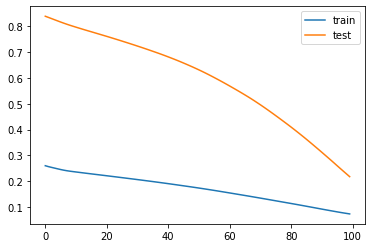

Train on 68 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.2724 - val_loss: 0.8037
Epoch 2/100
 - 0s - loss: 0.2512 - val_loss: 0.7609
Epoch 3/100
 - 0s - loss: 0.2309 - val_loss: 0.7204
Epoch 4/100
 - 0s - loss: 0.2170 - val_loss: 0.6841
Epoch 5/100
 - 0s - loss: 0.2001 - val_loss: 0.6391
Epoch 6/100
 - 0s - loss: 0.1836 - val_loss: 0.5900
Epoch 7/100
 - 0s - loss: 0.1666 - val_loss: 0.5351
Epoch 8/100
 - 0s - loss: 0.1484 - val_loss: 0.4768
Epoch 9/100
 - 0s - loss: 0.1286 - val_loss: 0.4090
Epoch 10/100
 - 0s - loss: 0.1087 - val_loss: 0.3390
Epoch 11/100
 - 0s - loss: 0.0892 - val_loss: 0.2627
Epoch 12/100
 - 0s - loss: 0.0709 - val_loss: 0.1837
Epoch 13/100
 - 0s - loss: 0.0550 - val_loss: 0.1122
Epoch 14/100
 - 0s - loss: 0.0415 - val_loss: 0.0775
Epoch 15/100
 - 0s - loss: 0.0332 - val_loss: 0.0497
Epoch 16/100
 - 0s - loss: 0.0268 - val_loss: 0.0411
Epoch 17/100
 - 0s - loss: 0.0234 - val_loss: 0.0519
Epoch 18/100
 - 0s - loss: 0.0203 - val_loss: 0.0586
Epoch 19/10

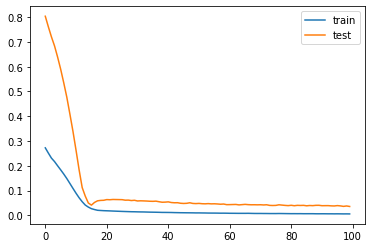

Train on 68 samples, validate on 17 samples
Epoch 1/100
 - 1s - loss: 0.3276 - val_loss: 0.9828
Epoch 2/100
 - 0s - loss: 0.3197 - val_loss: 0.9726
Epoch 3/100
 - 0s - loss: 0.3128 - val_loss: 0.9627
Epoch 4/100
 - 0s - loss: 0.3073 - val_loss: 0.9536
Epoch 5/100
 - 0s - loss: 0.3032 - val_loss: 0.9451
Epoch 6/100
 - 0s - loss: 0.2995 - val_loss: 0.9371
Epoch 7/100
 - 0s - loss: 0.2962 - val_loss: 0.9296
Epoch 8/100
 - 0s - loss: 0.2931 - val_loss: 0.9220
Epoch 9/100
 - 0s - loss: 0.2902 - val_loss: 0.9146
Epoch 10/100
 - 0s - loss: 0.2872 - val_loss: 0.9072
Epoch 11/100
 - 0s - loss: 0.2844 - val_loss: 0.8999
Epoch 12/100
 - 0s - loss: 0.2816 - val_loss: 0.8928
Epoch 13/100
 - 0s - loss: 0.2788 - val_loss: 0.8857
Epoch 14/100
 - 0s - loss: 0.2760 - val_loss: 0.8787
Epoch 15/100
 - 0s - loss: 0.2732 - val_loss: 0.8717
Epoch 16/100
 - 0s - loss: 0.2704 - val_loss: 0.8646
Epoch 17/100
 - 0s - loss: 0.2675 - val_loss: 0.8575
Epoch 18/100
 - 0s - loss: 0.2646 - val_loss: 0.8504
Epoch 19/10

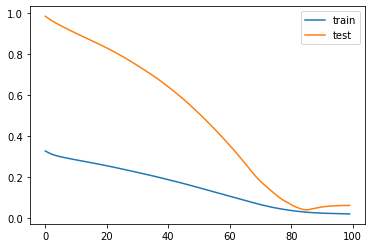

Train on 68 samples, validate on 17 samples
Epoch 1/100
 - 0s - loss: 0.2748 - val_loss: 0.8357
Epoch 2/100
 - 0s - loss: 0.2712 - val_loss: 0.8303
Epoch 3/100
 - 0s - loss: 0.2681 - val_loss: 0.8250
Epoch 4/100
 - 0s - loss: 0.2651 - val_loss: 0.8199
Epoch 5/100
 - 0s - loss: 0.2622 - val_loss: 0.8149
Epoch 6/100
 - 0s - loss: 0.2593 - val_loss: 0.8100
Epoch 7/100
 - 0s - loss: 0.2564 - val_loss: 0.8053
Epoch 8/100
 - 0s - loss: 0.2535 - val_loss: 0.8006
Epoch 9/100
 - 0s - loss: 0.2507 - val_loss: 0.7958
Epoch 10/100
 - 0s - loss: 0.2479 - val_loss: 0.7911
Epoch 11/100
 - 0s - loss: 0.2452 - val_loss: 0.7864
Epoch 12/100
 - 0s - loss: 0.2428 - val_loss: 0.7819
Epoch 13/100
 - 0s - loss: 0.2405 - val_loss: 0.7774
Epoch 14/100
 - 0s - loss: 0.2384 - val_loss: 0.7731
Epoch 15/100
 - 0s - loss: 0.2365 - val_loss: 0.7689
Epoch 16/100
 - 0s - loss: 0.2346 - val_loss: 0.7648
Epoch 17/100
 - 0s - loss: 0.2328 - val_loss: 0.7607
Epoch 18/100
 - 0s - loss: 0.2309 - val_loss: 0.7567
Epoch 19/10

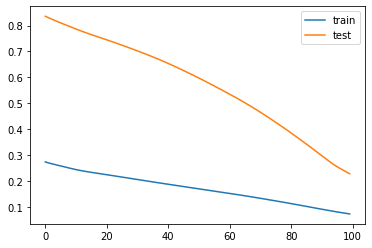

Train on 78 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.3223 - val_loss: 0.6265
Epoch 2/100
 - 0s - loss: 0.2976 - val_loss: 0.5784
Epoch 3/100
 - 0s - loss: 0.2779 - val_loss: 0.5370
Epoch 4/100
 - 0s - loss: 0.2601 - val_loss: 0.4964
Epoch 5/100
 - 0s - loss: 0.2441 - val_loss: 0.4598
Epoch 6/100
 - 0s - loss: 0.2305 - val_loss: 0.4286
Epoch 7/100
 - 0s - loss: 0.2184 - val_loss: 0.4017
Epoch 8/100
 - 0s - loss: 0.2082 - val_loss: 0.3781
Epoch 9/100
 - 0s - loss: 0.1992 - val_loss: 0.3590
Epoch 10/100
 - 0s - loss: 0.1915 - val_loss: 0.3416
Epoch 11/100
 - 0s - loss: 0.1840 - val_loss: 0.3228
Epoch 12/100
 - 0s - loss: 0.1769 - val_loss: 0.3082
Epoch 13/100
 - 0s - loss: 0.1696 - val_loss: 0.2945
Epoch 14/100
 - 0s - loss: 0.1622 - val_loss: 0.2822
Epoch 15/100
 - 0s - loss: 0.1553 - val_loss: 0.2710
Epoch 16/100
 - 0s - loss: 0.1484 - val_loss: 0.2615
Epoch 17/100
 - 0s - loss: 0.1419 - val_loss: 0.2538
Epoch 18/100
 - 0s - loss: 0.1354 - val_loss: 0.2440
Epoch 19/10

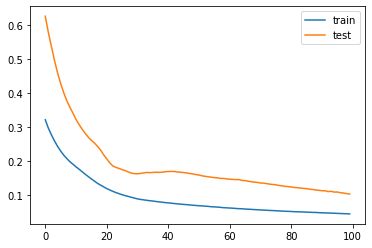

Train on 78 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.3588 - val_loss: 0.7543
Epoch 2/100
 - 0s - loss: 0.3529 - val_loss: 0.7471
Epoch 3/100
 - 0s - loss: 0.3473 - val_loss: 0.7401
Epoch 4/100
 - 0s - loss: 0.3417 - val_loss: 0.7330
Epoch 5/100
 - 0s - loss: 0.3361 - val_loss: 0.7260
Epoch 6/100
 - 0s - loss: 0.3311 - val_loss: 0.7194
Epoch 7/100
 - 0s - loss: 0.3268 - val_loss: 0.7132
Epoch 8/100
 - 0s - loss: 0.3228 - val_loss: 0.7072
Epoch 9/100
 - 0s - loss: 0.3190 - val_loss: 0.7013
Epoch 10/100
 - 0s - loss: 0.3154 - val_loss: 0.6956
Epoch 11/100
 - 0s - loss: 0.3119 - val_loss: 0.6899
Epoch 12/100
 - 0s - loss: 0.3085 - val_loss: 0.6843
Epoch 13/100
 - 0s - loss: 0.3050 - val_loss: 0.6786
Epoch 14/100
 - 0s - loss: 0.3016 - val_loss: 0.6730
Epoch 15/100
 - 0s - loss: 0.2983 - val_loss: 0.6674
Epoch 16/100
 - 0s - loss: 0.2949 - val_loss: 0.6619
Epoch 17/100
 - 0s - loss: 0.2915 - val_loss: 0.6563
Epoch 18/100
 - 0s - loss: 0.2881 - val_loss: 0.6507
Epoch 19/10

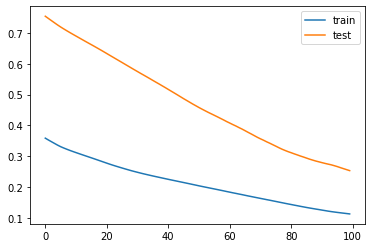

Train on 78 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.3335 - val_loss: 0.6733
Epoch 2/100
 - 0s - loss: 0.3311 - val_loss: 0.6707
Epoch 3/100
 - 0s - loss: 0.3291 - val_loss: 0.6678
Epoch 4/100
 - 0s - loss: 0.3271 - val_loss: 0.6649
Epoch 5/100
 - 0s - loss: 0.3251 - val_loss: 0.6620
Epoch 6/100
 - 0s - loss: 0.3231 - val_loss: 0.6591
Epoch 7/100
 - 0s - loss: 0.3211 - val_loss: 0.6561
Epoch 8/100
 - 0s - loss: 0.3191 - val_loss: 0.6532
Epoch 9/100
 - 0s - loss: 0.3172 - val_loss: 0.6502
Epoch 10/100
 - 0s - loss: 0.3152 - val_loss: 0.6473
Epoch 11/100
 - 0s - loss: 0.3132 - val_loss: 0.6444
Epoch 12/100
 - 0s - loss: 0.3113 - val_loss: 0.6415
Epoch 13/100
 - 0s - loss: 0.3093 - val_loss: 0.6386
Epoch 14/100
 - 0s - loss: 0.3073 - val_loss: 0.6357
Epoch 15/100
 - 0s - loss: 0.3054 - val_loss: 0.6328
Epoch 16/100
 - 0s - loss: 0.3034 - val_loss: 0.6298
Epoch 17/100
 - 0s - loss: 0.3014 - val_loss: 0.6269
Epoch 18/100
 - 0s - loss: 0.2994 - val_loss: 0.6239
Epoch 19/10

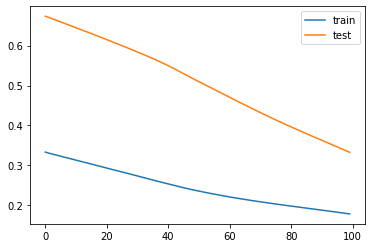

Train on 77 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2393 - val_loss: 0.8519
Epoch 2/100
 - 0s - loss: 0.2263 - val_loss: 0.8349
Epoch 3/100
 - 0s - loss: 0.2201 - val_loss: 0.8255
Epoch 4/100
 - 0s - loss: 0.2135 - val_loss: 0.8139
Epoch 5/100
 - 0s - loss: 0.2073 - val_loss: 0.8019
Epoch 6/100
 - 0s - loss: 0.2008 - val_loss: 0.7881
Epoch 7/100
 - 0s - loss: 0.1936 - val_loss: 0.7726
Epoch 8/100
 - 0s - loss: 0.1863 - val_loss: 0.7550
Epoch 9/100
 - 0s - loss: 0.1783 - val_loss: 0.7353
Epoch 10/100
 - 0s - loss: 0.1698 - val_loss: 0.7136
Epoch 11/100
 - 0s - loss: 0.1609 - val_loss: 0.6890
Epoch 12/100
 - 0s - loss: 0.1520 - val_loss: 0.6610
Epoch 13/100
 - 0s - loss: 0.1444 - val_loss: 0.6325
Epoch 14/100
 - 0s - loss: 0.1363 - val_loss: 0.6000
Epoch 15/100
 - 0s - loss: 0.1288 - val_loss: 0.5681
Epoch 16/100
 - 0s - loss: 0.1211 - val_loss: 0.5333
Epoch 17/100
 - 0s - loss: 0.1134 - val_loss: 0.4976
Epoch 18/100
 - 0s - loss: 0.1053 - val_loss: 0.4595
Epoch 19/10

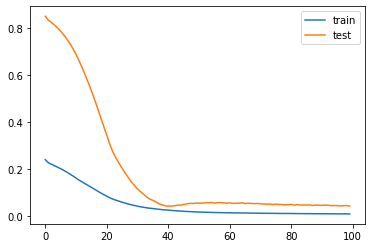

Train on 77 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2306 - val_loss: 0.8685
Epoch 2/100
 - 0s - loss: 0.2258 - val_loss: 0.8633
Epoch 3/100
 - 0s - loss: 0.2218 - val_loss: 0.8583
Epoch 4/100
 - 0s - loss: 0.2186 - val_loss: 0.8540
Epoch 5/100
 - 0s - loss: 0.2162 - val_loss: 0.8504
Epoch 6/100
 - 0s - loss: 0.2142 - val_loss: 0.8474
Epoch 7/100
 - 0s - loss: 0.2123 - val_loss: 0.8447
Epoch 8/100
 - 0s - loss: 0.2104 - val_loss: 0.8421
Epoch 9/100
 - 0s - loss: 0.2085 - val_loss: 0.8395
Epoch 10/100
 - 0s - loss: 0.2067 - val_loss: 0.8370
Epoch 11/100
 - 0s - loss: 0.2048 - val_loss: 0.8344
Epoch 12/100
 - 0s - loss: 0.2030 - val_loss: 0.8317
Epoch 13/100
 - 0s - loss: 0.2013 - val_loss: 0.8291
Epoch 14/100
 - 0s - loss: 0.1995 - val_loss: 0.8264
Epoch 15/100
 - 0s - loss: 0.1978 - val_loss: 0.8237
Epoch 16/100
 - 0s - loss: 0.1960 - val_loss: 0.8210
Epoch 17/100
 - 0s - loss: 0.1942 - val_loss: 0.8183
Epoch 18/100
 - 0s - loss: 0.1924 - val_loss: 0.8155
Epoch 19/10

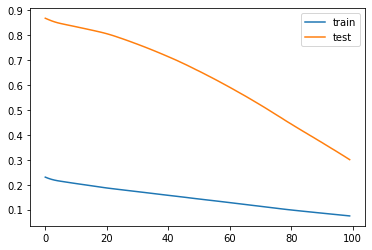

Train on 77 samples, validate on 20 samples
Epoch 1/100
 - 0s - loss: 0.2220 - val_loss: 0.8576
Epoch 2/100
 - 0s - loss: 0.2198 - val_loss: 0.8547
Epoch 3/100
 - 0s - loss: 0.2180 - val_loss: 0.8517
Epoch 4/100
 - 0s - loss: 0.2162 - val_loss: 0.8489
Epoch 5/100
 - 0s - loss: 0.2148 - val_loss: 0.8464
Epoch 6/100
 - 0s - loss: 0.2134 - val_loss: 0.8440
Epoch 7/100
 - 0s - loss: 0.2122 - val_loss: 0.8419
Epoch 8/100
 - 0s - loss: 0.2110 - val_loss: 0.8399
Epoch 9/100
 - 0s - loss: 0.2098 - val_loss: 0.8380
Epoch 10/100
 - 0s - loss: 0.2086 - val_loss: 0.8361
Epoch 11/100
 - 0s - loss: 0.2074 - val_loss: 0.8342
Epoch 12/100
 - 0s - loss: 0.2062 - val_loss: 0.8322
Epoch 13/100
 - 0s - loss: 0.2050 - val_loss: 0.8303
Epoch 14/100
 - 0s - loss: 0.2038 - val_loss: 0.8283
Epoch 15/100
 - 0s - loss: 0.2027 - val_loss: 0.8263
Epoch 16/100
 - 0s - loss: 0.2016 - val_loss: 0.8243
Epoch 17/100
 - 0s - loss: 0.2004 - val_loss: 0.8223
Epoch 18/100
 - 0s - loss: 0.1993 - val_loss: 0.8202
Epoch 19/10

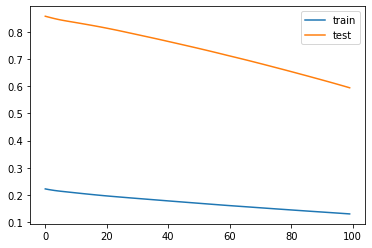

Train on 76 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2160 - val_loss: 0.8465
Epoch 2/100
 - 0s - loss: 0.2083 - val_loss: 0.8296
Epoch 3/100
 - 0s - loss: 0.2021 - val_loss: 0.8137
Epoch 4/100
 - 0s - loss: 0.1954 - val_loss: 0.7972
Epoch 5/100
 - 0s - loss: 0.1886 - val_loss: 0.7791
Epoch 6/100
 - 0s - loss: 0.1820 - val_loss: 0.7607
Epoch 7/100
 - 0s - loss: 0.1750 - val_loss: 0.7414
Epoch 8/100
 - 0s - loss: 0.1677 - val_loss: 0.7197
Epoch 9/100
 - 0s - loss: 0.1609 - val_loss: 0.6979
Epoch 10/100
 - 0s - loss: 0.1543 - val_loss: 0.6753
Epoch 11/100
 - 0s - loss: 0.1478 - val_loss: 0.6505
Epoch 12/100
 - 0s - loss: 0.1414 - val_loss: 0.6244
Epoch 13/100
 - 0s - loss: 0.1351 - val_loss: 0.5978
Epoch 14/100
 - 0s - loss: 0.1290 - val_loss: 0.5703
Epoch 15/100
 - 0s - loss: 0.1224 - val_loss: 0.5403
Epoch 16/100
 - 0s - loss: 0.1161 - val_loss: 0.5106
Epoch 17/100
 - 0s - loss: 0.1097 - val_loss: 0.4787
Epoch 18/100
 - 0s - loss: 0.1031 - val_loss: 0.4449
Epoch 19/10

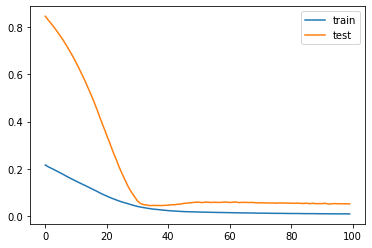

Train on 76 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2098 - val_loss: 0.8209
Epoch 2/100
 - 0s - loss: 0.2043 - val_loss: 0.8144
Epoch 3/100
 - 0s - loss: 0.1995 - val_loss: 0.8080
Epoch 4/100
 - 0s - loss: 0.1958 - val_loss: 0.8026
Epoch 5/100
 - 0s - loss: 0.1937 - val_loss: 0.7986
Epoch 6/100
 - 0s - loss: 0.1918 - val_loss: 0.7952
Epoch 7/100
 - 0s - loss: 0.1900 - val_loss: 0.7920
Epoch 8/100
 - 0s - loss: 0.1881 - val_loss: 0.7887
Epoch 9/100
 - 0s - loss: 0.1863 - val_loss: 0.7854
Epoch 10/100
 - 0s - loss: 0.1845 - val_loss: 0.7822
Epoch 11/100
 - 0s - loss: 0.1827 - val_loss: 0.7789
Epoch 12/100
 - 0s - loss: 0.1809 - val_loss: 0.7756
Epoch 13/100
 - 0s - loss: 0.1791 - val_loss: 0.7722
Epoch 14/100
 - 0s - loss: 0.1774 - val_loss: 0.7684
Epoch 15/100
 - 0s - loss: 0.1757 - val_loss: 0.7644
Epoch 16/100
 - 0s - loss: 0.1741 - val_loss: 0.7603
Epoch 17/100
 - 0s - loss: 0.1724 - val_loss: 0.7561
Epoch 18/100
 - 0s - loss: 0.1708 - val_loss: 0.7519
Epoch 19/10

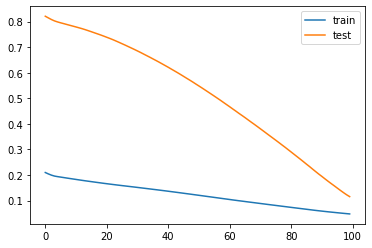

Train on 76 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2619 - val_loss: 0.9388
Epoch 2/100
 - 0s - loss: 0.2581 - val_loss: 0.9334
Epoch 3/100
 - 0s - loss: 0.2542 - val_loss: 0.9280
Epoch 4/100
 - 0s - loss: 0.2504 - val_loss: 0.9226
Epoch 5/100
 - 0s - loss: 0.2466 - val_loss: 0.9173
Epoch 6/100
 - 0s - loss: 0.2429 - val_loss: 0.9120
Epoch 7/100
 - 0s - loss: 0.2394 - val_loss: 0.9068
Epoch 8/100
 - 0s - loss: 0.2359 - val_loss: 0.9018
Epoch 9/100
 - 0s - loss: 0.2325 - val_loss: 0.8968
Epoch 10/100
 - 0s - loss: 0.2292 - val_loss: 0.8919
Epoch 11/100
 - 0s - loss: 0.2260 - val_loss: 0.8871
Epoch 12/100
 - 0s - loss: 0.2229 - val_loss: 0.8824
Epoch 13/100
 - 0s - loss: 0.2199 - val_loss: 0.8777
Epoch 14/100
 - 0s - loss: 0.2169 - val_loss: 0.8731
Epoch 15/100
 - 0s - loss: 0.2139 - val_loss: 0.8686
Epoch 16/100
 - 0s - loss: 0.2112 - val_loss: 0.8642
Epoch 17/100
 - 0s - loss: 0.2086 - val_loss: 0.8599
Epoch 18/100
 - 0s - loss: 0.2063 - val_loss: 0.8558
Epoch 19/10

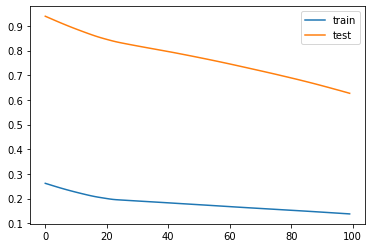

Train on 73 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.2733 - val_loss: 0.8567
Epoch 2/100
 - 0s - loss: 0.2575 - val_loss: 0.8260
Epoch 3/100
 - 0s - loss: 0.2413 - val_loss: 0.7941
Epoch 4/100
 - 0s - loss: 0.2254 - val_loss: 0.7617
Epoch 5/100
 - 0s - loss: 0.2116 - val_loss: 0.7307
Epoch 6/100
 - 0s - loss: 0.2004 - val_loss: 0.7015
Epoch 7/100
 - 0s - loss: 0.1911 - val_loss: 0.6732
Epoch 8/100
 - 0s - loss: 0.1817 - val_loss: 0.6426
Epoch 9/100
 - 0s - loss: 0.1719 - val_loss: 0.6103
Epoch 10/100
 - 0s - loss: 0.1618 - val_loss: 0.5752
Epoch 11/100
 - 0s - loss: 0.1515 - val_loss: 0.5383
Epoch 12/100
 - 0s - loss: 0.1406 - val_loss: 0.4979
Epoch 13/100
 - 0s - loss: 0.1300 - val_loss: 0.4568
Epoch 14/100
 - 0s - loss: 0.1189 - val_loss: 0.4127
Epoch 15/100
 - 0s - loss: 0.1074 - val_loss: 0.3653
Epoch 16/100
 - 0s - loss: 0.0962 - val_loss: 0.3181
Epoch 17/100
 - 0s - loss: 0.0856 - val_loss: 0.2674
Epoch 18/100
 - 0s - loss: 0.0751 - val_loss: 0.2259
Epoch 19/10

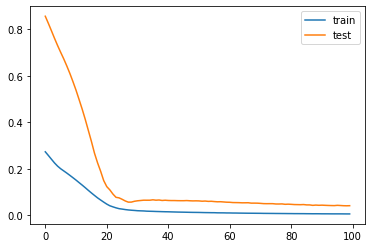

Train on 73 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.2458 - val_loss: 0.9005
Epoch 2/100
 - 0s - loss: 0.2417 - val_loss: 0.8938
Epoch 3/100
 - 0s - loss: 0.2390 - val_loss: 0.8880
Epoch 4/100
 - 0s - loss: 0.2366 - val_loss: 0.8827
Epoch 5/100
 - 0s - loss: 0.2342 - val_loss: 0.8776
Epoch 6/100
 - 0s - loss: 0.2318 - val_loss: 0.8726
Epoch 7/100
 - 0s - loss: 0.2294 - val_loss: 0.8677
Epoch 8/100
 - 0s - loss: 0.2270 - val_loss: 0.8628
Epoch 9/100
 - 0s - loss: 0.2247 - val_loss: 0.8577
Epoch 10/100
 - 0s - loss: 0.2224 - val_loss: 0.8526
Epoch 11/100
 - 0s - loss: 0.2201 - val_loss: 0.8476
Epoch 12/100
 - 0s - loss: 0.2179 - val_loss: 0.8424
Epoch 13/100
 - 0s - loss: 0.2156 - val_loss: 0.8372
Epoch 14/100
 - 0s - loss: 0.2134 - val_loss: 0.8320
Epoch 15/100
 - 0s - loss: 0.2112 - val_loss: 0.8265
Epoch 16/100
 - 0s - loss: 0.2090 - val_loss: 0.8209
Epoch 17/100
 - 0s - loss: 0.2069 - val_loss: 0.8155
Epoch 18/100
 - 0s - loss: 0.2047 - val_loss: 0.8100
Epoch 19/10

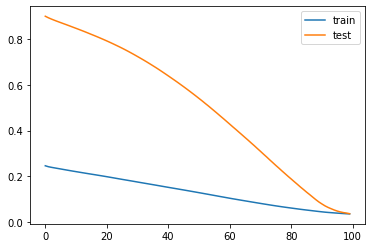

Train on 73 samples, validate on 19 samples
Epoch 1/100
 - 0s - loss: 0.2431 - val_loss: 0.8114
Epoch 2/100
 - 0s - loss: 0.2413 - val_loss: 0.8099
Epoch 3/100
 - 0s - loss: 0.2400 - val_loss: 0.8081
Epoch 4/100
 - 0s - loss: 0.2388 - val_loss: 0.8063
Epoch 5/100
 - 0s - loss: 0.2376 - val_loss: 0.8044
Epoch 6/100
 - 0s - loss: 0.2363 - val_loss: 0.8025
Epoch 7/100
 - 0s - loss: 0.2351 - val_loss: 0.8006
Epoch 8/100
 - 0s - loss: 0.2339 - val_loss: 0.7987
Epoch 9/100
 - 0s - loss: 0.2327 - val_loss: 0.7968
Epoch 10/100
 - 0s - loss: 0.2314 - val_loss: 0.7948
Epoch 11/100
 - 0s - loss: 0.2302 - val_loss: 0.7929
Epoch 12/100
 - 0s - loss: 0.2290 - val_loss: 0.7910
Epoch 13/100
 - 0s - loss: 0.2277 - val_loss: 0.7890
Epoch 14/100
 - 0s - loss: 0.2265 - val_loss: 0.7870
Epoch 15/100
 - 0s - loss: 0.2252 - val_loss: 0.7850
Epoch 16/100
 - 0s - loss: 0.2239 - val_loss: 0.7830
Epoch 17/100
 - 0s - loss: 0.2227 - val_loss: 0.7810
Epoch 18/100
 - 0s - loss: 0.2214 - val_loss: 0.7789
Epoch 19/10

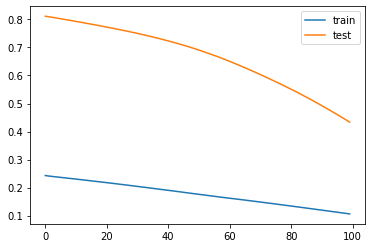

Train on 80 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.3500 - val_loss: 0.7172
Epoch 2/100
 - 0s - loss: 0.3301 - val_loss: 0.6865
Epoch 3/100
 - 0s - loss: 0.3124 - val_loss: 0.6589
Epoch 4/100
 - 0s - loss: 0.2978 - val_loss: 0.6325
Epoch 5/100
 - 0s - loss: 0.2839 - val_loss: 0.6060
Epoch 6/100
 - 0s - loss: 0.2700 - val_loss: 0.5787
Epoch 7/100
 - 0s - loss: 0.2565 - val_loss: 0.5507
Epoch 8/100
 - 0s - loss: 0.2445 - val_loss: 0.5261
Epoch 9/100
 - 0s - loss: 0.2348 - val_loss: 0.5030
Epoch 10/100
 - 0s - loss: 0.2264 - val_loss: 0.4809
Epoch 11/100
 - 0s - loss: 0.2178 - val_loss: 0.4585
Epoch 12/100
 - 0s - loss: 0.2107 - val_loss: 0.4426
Epoch 13/100
 - 0s - loss: 0.2043 - val_loss: 0.4270
Epoch 14/100
 - 0s - loss: 0.1983 - val_loss: 0.4134
Epoch 15/100
 - 0s - loss: 0.1924 - val_loss: 0.4008
Epoch 16/100
 - 0s - loss: 0.1867 - val_loss: 0.3887
Epoch 17/100
 - 0s - loss: 0.1808 - val_loss: 0.3763
Epoch 18/100
 - 0s - loss: 0.1753 - val_loss: 0.3667
Epoch 19/10

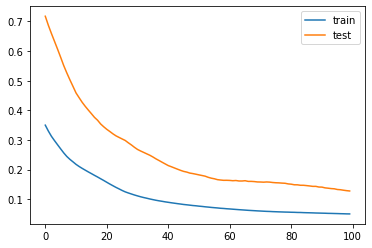

Train on 80 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.3316 - val_loss: 0.7531
Epoch 2/100
 - 0s - loss: 0.3272 - val_loss: 0.7472
Epoch 3/100
 - 0s - loss: 0.3231 - val_loss: 0.7412
Epoch 4/100
 - 0s - loss: 0.3192 - val_loss: 0.7355
Epoch 5/100
 - 0s - loss: 0.3154 - val_loss: 0.7298
Epoch 6/100
 - 0s - loss: 0.3116 - val_loss: 0.7241
Epoch 7/100
 - 0s - loss: 0.3080 - val_loss: 0.7187
Epoch 8/100
 - 0s - loss: 0.3046 - val_loss: 0.7134
Epoch 9/100
 - 0s - loss: 0.3013 - val_loss: 0.7082
Epoch 10/100
 - 0s - loss: 0.2981 - val_loss: 0.7030
Epoch 11/100
 - 0s - loss: 0.2950 - val_loss: 0.6978
Epoch 12/100
 - 0s - loss: 0.2919 - val_loss: 0.6927
Epoch 13/100
 - 0s - loss: 0.2890 - val_loss: 0.6877
Epoch 14/100
 - 0s - loss: 0.2860 - val_loss: 0.6826
Epoch 15/100
 - 0s - loss: 0.2830 - val_loss: 0.6775
Epoch 16/100
 - 0s - loss: 0.2801 - val_loss: 0.6724
Epoch 17/100
 - 0s - loss: 0.2771 - val_loss: 0.6673
Epoch 18/100
 - 0s - loss: 0.2741 - val_loss: 0.6622
Epoch 19/10

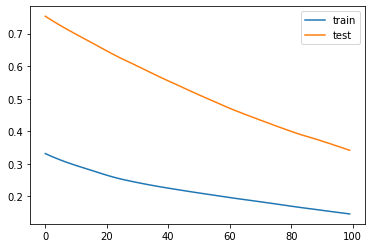

Train on 80 samples, validate on 20 samples
Epoch 1/100
 - 0s - loss: 0.3474 - val_loss: 0.7414
Epoch 2/100
 - 0s - loss: 0.3458 - val_loss: 0.7392
Epoch 3/100
 - 0s - loss: 0.3444 - val_loss: 0.7369
Epoch 4/100
 - 0s - loss: 0.3430 - val_loss: 0.7346
Epoch 5/100
 - 0s - loss: 0.3415 - val_loss: 0.7322
Epoch 6/100
 - 0s - loss: 0.3401 - val_loss: 0.7299
Epoch 7/100
 - 0s - loss: 0.3387 - val_loss: 0.7275
Epoch 8/100
 - 0s - loss: 0.3374 - val_loss: 0.7252
Epoch 9/100
 - 0s - loss: 0.3360 - val_loss: 0.7229
Epoch 10/100
 - 0s - loss: 0.3346 - val_loss: 0.7206
Epoch 11/100
 - 0s - loss: 0.3332 - val_loss: 0.7183
Epoch 12/100
 - 0s - loss: 0.3319 - val_loss: 0.7160
Epoch 13/100
 - 0s - loss: 0.3305 - val_loss: 0.7137
Epoch 14/100
 - 0s - loss: 0.3292 - val_loss: 0.7114
Epoch 15/100
 - 0s - loss: 0.3278 - val_loss: 0.7091
Epoch 16/100
 - 0s - loss: 0.3265 - val_loss: 0.7069
Epoch 17/100
 - 0s - loss: 0.3252 - val_loss: 0.7046
Epoch 18/100
 - 0s - loss: 0.3239 - val_loss: 0.7024
Epoch 19/10

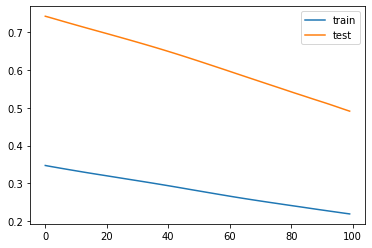

Train on 79 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2238 - val_loss: 0.8777
Epoch 2/100
 - 0s - loss: 0.2126 - val_loss: 0.8597
Epoch 3/100
 - 0s - loss: 0.2010 - val_loss: 0.8417
Epoch 4/100
 - 0s - loss: 0.1935 - val_loss: 0.8293
Epoch 5/100
 - 0s - loss: 0.1891 - val_loss: 0.8188
Epoch 6/100
 - 0s - loss: 0.1843 - val_loss: 0.8086
Epoch 7/100
 - 0s - loss: 0.1793 - val_loss: 0.7968
Epoch 8/100
 - 0s - loss: 0.1748 - val_loss: 0.7831
Epoch 9/100
 - 0s - loss: 0.1700 - val_loss: 0.7667
Epoch 10/100
 - 0s - loss: 0.1655 - val_loss: 0.7508
Epoch 11/100
 - 0s - loss: 0.1608 - val_loss: 0.7335
Epoch 12/100
 - 0s - loss: 0.1563 - val_loss: 0.7156
Epoch 13/100
 - 0s - loss: 0.1516 - val_loss: 0.6968
Epoch 14/100
 - 0s - loss: 0.1470 - val_loss: 0.6774
Epoch 15/100
 - 0s - loss: 0.1422 - val_loss: 0.6568
Epoch 16/100
 - 0s - loss: 0.1374 - val_loss: 0.6348
Epoch 17/100
 - 0s - loss: 0.1326 - val_loss: 0.6125
Epoch 18/100
 - 0s - loss: 0.1276 - val_loss: 0.5882
Epoch 19/10

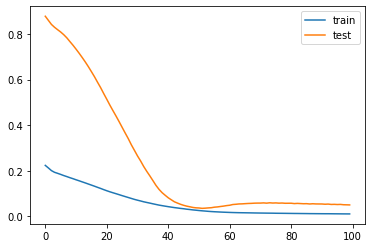

Train on 79 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2081 - val_loss: 0.8753
Epoch 2/100
 - 0s - loss: 0.2056 - val_loss: 0.8719
Epoch 3/100
 - 0s - loss: 0.2038 - val_loss: 0.8686
Epoch 4/100
 - 0s - loss: 0.2021 - val_loss: 0.8655
Epoch 5/100
 - 0s - loss: 0.2005 - val_loss: 0.8624
Epoch 6/100
 - 0s - loss: 0.1993 - val_loss: 0.8599
Epoch 7/100
 - 0s - loss: 0.1983 - val_loss: 0.8579
Epoch 8/100
 - 0s - loss: 0.1974 - val_loss: 0.8560
Epoch 9/100
 - 0s - loss: 0.1964 - val_loss: 0.8540
Epoch 10/100
 - 0s - loss: 0.1955 - val_loss: 0.8521
Epoch 11/100
 - 0s - loss: 0.1946 - val_loss: 0.8500
Epoch 12/100
 - 0s - loss: 0.1937 - val_loss: 0.8479
Epoch 13/100
 - 0s - loss: 0.1928 - val_loss: 0.8457
Epoch 14/100
 - 0s - loss: 0.1918 - val_loss: 0.8435
Epoch 15/100
 - 0s - loss: 0.1910 - val_loss: 0.8414
Epoch 16/100
 - 0s - loss: 0.1900 - val_loss: 0.8391
Epoch 17/100
 - 0s - loss: 0.1892 - val_loss: 0.8370
Epoch 18/100
 - 0s - loss: 0.1882 - val_loss: 0.8345
Epoch 19/10

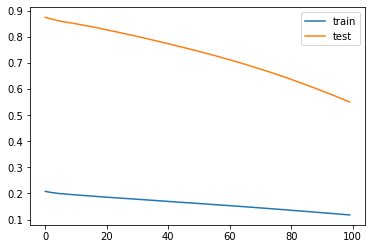

Train on 79 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2552 - val_loss: 0.9487
Epoch 2/100
 - 0s - loss: 0.2519 - val_loss: 0.9447
Epoch 3/100
 - 0s - loss: 0.2487 - val_loss: 0.9407
Epoch 4/100
 - 0s - loss: 0.2455 - val_loss: 0.9366
Epoch 5/100
 - 0s - loss: 0.2423 - val_loss: 0.9326
Epoch 6/100
 - 0s - loss: 0.2391 - val_loss: 0.9286
Epoch 7/100
 - 0s - loss: 0.2358 - val_loss: 0.9246
Epoch 8/100
 - 0s - loss: 0.2326 - val_loss: 0.9206
Epoch 9/100
 - 0s - loss: 0.2297 - val_loss: 0.9167
Epoch 10/100
 - 0s - loss: 0.2270 - val_loss: 0.9130
Epoch 11/100
 - 0s - loss: 0.2247 - val_loss: 0.9096
Epoch 12/100
 - 0s - loss: 0.2225 - val_loss: 0.9063
Epoch 13/100
 - 0s - loss: 0.2204 - val_loss: 0.9032
Epoch 14/100
 - 0s - loss: 0.2184 - val_loss: 0.9002
Epoch 15/100
 - 0s - loss: 0.2167 - val_loss: 0.8974
Epoch 16/100
 - 0s - loss: 0.2152 - val_loss: 0.8948
Epoch 17/100
 - 0s - loss: 0.2141 - val_loss: 0.8923
Epoch 18/100
 - 0s - loss: 0.2131 - val_loss: 0.8900
Epoch 19/10

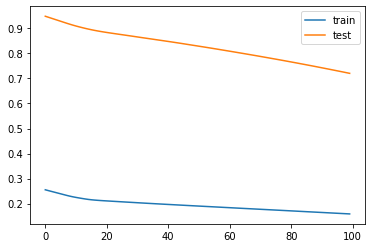

Train on 78 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2235 - val_loss: 0.8617
Epoch 2/100
 - 0s - loss: 0.2085 - val_loss: 0.8386
Epoch 3/100
 - 0s - loss: 0.1979 - val_loss: 0.8202
Epoch 4/100
 - 0s - loss: 0.1910 - val_loss: 0.8050
Epoch 5/100
 - 0s - loss: 0.1836 - val_loss: 0.7888
Epoch 6/100
 - 0s - loss: 0.1763 - val_loss: 0.7709
Epoch 7/100
 - 0s - loss: 0.1695 - val_loss: 0.7514
Epoch 8/100
 - 0s - loss: 0.1631 - val_loss: 0.7324
Epoch 9/100
 - 0s - loss: 0.1570 - val_loss: 0.7129
Epoch 10/100
 - 0s - loss: 0.1513 - val_loss: 0.6933
Epoch 11/100
 - 0s - loss: 0.1463 - val_loss: 0.6736
Epoch 12/100
 - 0s - loss: 0.1410 - val_loss: 0.6524
Epoch 13/100
 - 0s - loss: 0.1359 - val_loss: 0.6309
Epoch 14/100
 - 0s - loss: 0.1306 - val_loss: 0.6082
Epoch 15/100
 - 0s - loss: 0.1255 - val_loss: 0.5858
Epoch 16/100
 - 0s - loss: 0.1200 - val_loss: 0.5605
Epoch 17/100
 - 0s - loss: 0.1151 - val_loss: 0.5372
Epoch 18/100
 - 0s - loss: 0.1100 - val_loss: 0.5121
Epoch 19/10

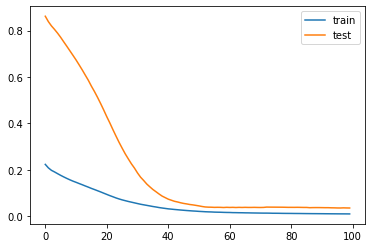

Train on 78 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2482 - val_loss: 0.8863
Epoch 2/100
 - 0s - loss: 0.2426 - val_loss: 0.8801
Epoch 3/100
 - 0s - loss: 0.2373 - val_loss: 0.8739
Epoch 4/100
 - 0s - loss: 0.2320 - val_loss: 0.8677
Epoch 5/100
 - 0s - loss: 0.2268 - val_loss: 0.8615
Epoch 6/100
 - 0s - loss: 0.2215 - val_loss: 0.8553
Epoch 7/100
 - 0s - loss: 0.2162 - val_loss: 0.8491
Epoch 8/100
 - 0s - loss: 0.2109 - val_loss: 0.8428
Epoch 9/100
 - 0s - loss: 0.2058 - val_loss: 0.8368
Epoch 10/100
 - 0s - loss: 0.2022 - val_loss: 0.8319
Epoch 11/100
 - 0s - loss: 0.1996 - val_loss: 0.8276
Epoch 12/100
 - 0s - loss: 0.1974 - val_loss: 0.8237
Epoch 13/100
 - 0s - loss: 0.1956 - val_loss: 0.8200
Epoch 14/100
 - 0s - loss: 0.1941 - val_loss: 0.8167
Epoch 15/100
 - 0s - loss: 0.1927 - val_loss: 0.8136
Epoch 16/100
 - 0s - loss: 0.1914 - val_loss: 0.8106
Epoch 17/100
 - 0s - loss: 0.1901 - val_loss: 0.8075
Epoch 18/100
 - 0s - loss: 0.1888 - val_loss: 0.8044
Epoch 19/10

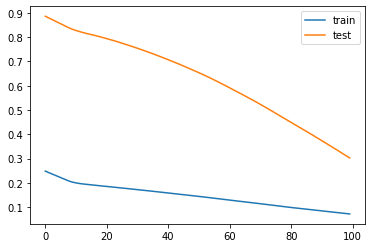

Train on 78 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2162 - val_loss: 0.8307
Epoch 2/100
 - 0s - loss: 0.2147 - val_loss: 0.8290
Epoch 3/100
 - 0s - loss: 0.2134 - val_loss: 0.8272
Epoch 4/100
 - 0s - loss: 0.2121 - val_loss: 0.8253
Epoch 5/100
 - 0s - loss: 0.2109 - val_loss: 0.8234
Epoch 6/100
 - 0s - loss: 0.2097 - val_loss: 0.8216
Epoch 7/100
 - 0s - loss: 0.2086 - val_loss: 0.8199
Epoch 8/100
 - 0s - loss: 0.2075 - val_loss: 0.8182
Epoch 9/100
 - 0s - loss: 0.2064 - val_loss: 0.8165
Epoch 10/100
 - 0s - loss: 0.2054 - val_loss: 0.8148
Epoch 11/100
 - 0s - loss: 0.2044 - val_loss: 0.8131
Epoch 12/100
 - 0s - loss: 0.2034 - val_loss: 0.8115
Epoch 13/100
 - 0s - loss: 0.2026 - val_loss: 0.8100
Epoch 14/100
 - 0s - loss: 0.2018 - val_loss: 0.8086
Epoch 15/100
 - 0s - loss: 0.2010 - val_loss: 0.8072
Epoch 16/100
 - 0s - loss: 0.2002 - val_loss: 0.8059
Epoch 17/100
 - 0s - loss: 0.1995 - val_loss: 0.8046
Epoch 18/100
 - 0s - loss: 0.1988 - val_loss: 0.8033
Epoch 19/10

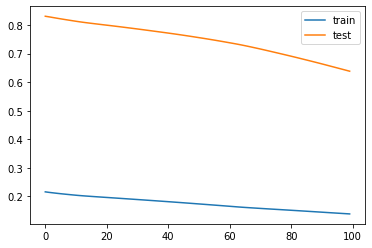

Train on 75 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.2475 - val_loss: 0.8902
Epoch 2/100
 - 0s - loss: 0.2327 - val_loss: 0.8627
Epoch 3/100
 - 0s - loss: 0.2214 - val_loss: 0.8427
Epoch 4/100
 - 0s - loss: 0.2145 - val_loss: 0.8267
Epoch 5/100
 - 0s - loss: 0.2067 - val_loss: 0.8090
Epoch 6/100
 - 0s - loss: 0.1990 - val_loss: 0.7881
Epoch 7/100
 - 0s - loss: 0.1918 - val_loss: 0.7665
Epoch 8/100
 - 0s - loss: 0.1842 - val_loss: 0.7418
Epoch 9/100
 - 0s - loss: 0.1764 - val_loss: 0.7160
Epoch 10/100
 - 0s - loss: 0.1679 - val_loss: 0.6869
Epoch 11/100
 - 0s - loss: 0.1591 - val_loss: 0.6551
Epoch 12/100
 - 0s - loss: 0.1501 - val_loss: 0.6217
Epoch 13/100
 - 0s - loss: 0.1408 - val_loss: 0.5857
Epoch 14/100
 - 0s - loss: 0.1316 - val_loss: 0.5480
Epoch 15/100
 - 0s - loss: 0.1222 - val_loss: 0.5083
Epoch 16/100
 - 0s - loss: 0.1128 - val_loss: 0.4679
Epoch 17/100
 - 0s - loss: 0.1033 - val_loss: 0.4242
Epoch 18/100
 - 0s - loss: 0.0941 - val_loss: 0.3789
Epoch 19/10

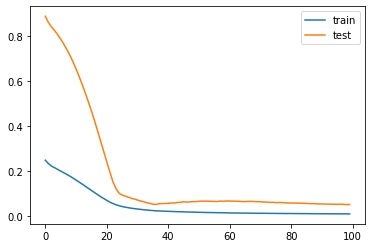

Train on 75 samples, validate on 19 samples
Epoch 1/100
 - 1s - loss: 0.2450 - val_loss: 0.8907
Epoch 2/100
 - 0s - loss: 0.2414 - val_loss: 0.8873
Epoch 3/100
 - 0s - loss: 0.2383 - val_loss: 0.8839
Epoch 4/100
 - 0s - loss: 0.2352 - val_loss: 0.8804
Epoch 5/100
 - 0s - loss: 0.2322 - val_loss: 0.8768
Epoch 6/100
 - 0s - loss: 0.2292 - val_loss: 0.8733
Epoch 7/100
 - 0s - loss: 0.2266 - val_loss: 0.8701
Epoch 8/100
 - 0s - loss: 0.2246 - val_loss: 0.8672
Epoch 9/100
 - 0s - loss: 0.2229 - val_loss: 0.8645
Epoch 10/100
 - 0s - loss: 0.2212 - val_loss: 0.8619
Epoch 11/100
 - 0s - loss: 0.2196 - val_loss: 0.8593
Epoch 12/100
 - 0s - loss: 0.2180 - val_loss: 0.8566
Epoch 13/100
 - 0s - loss: 0.2164 - val_loss: 0.8539
Epoch 14/100
 - 0s - loss: 0.2147 - val_loss: 0.8511
Epoch 15/100
 - 0s - loss: 0.2131 - val_loss: 0.8481
Epoch 16/100
 - 0s - loss: 0.2117 - val_loss: 0.8450
Epoch 17/100
 - 0s - loss: 0.2103 - val_loss: 0.8414
Epoch 18/100
 - 0s - loss: 0.2090 - val_loss: 0.8378
Epoch 19/10

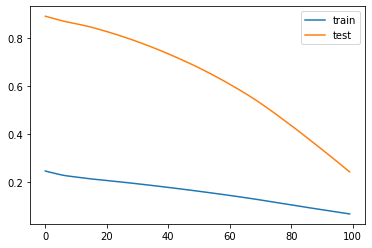

Train on 75 samples, validate on 19 samples
Epoch 1/100
 - 0s - loss: 0.2640 - val_loss: 0.9413
Epoch 2/100
 - 0s - loss: 0.2615 - val_loss: 0.9381
Epoch 3/100
 - 0s - loss: 0.2591 - val_loss: 0.9348
Epoch 4/100
 - 0s - loss: 0.2568 - val_loss: 0.9315
Epoch 5/100
 - 0s - loss: 0.2545 - val_loss: 0.9282
Epoch 6/100
 - 0s - loss: 0.2522 - val_loss: 0.9249
Epoch 7/100
 - 0s - loss: 0.2499 - val_loss: 0.9216
Epoch 8/100
 - 0s - loss: 0.2476 - val_loss: 0.9184
Epoch 9/100
 - 0s - loss: 0.2453 - val_loss: 0.9151
Epoch 10/100
 - 0s - loss: 0.2431 - val_loss: 0.9119
Epoch 11/100
 - 0s - loss: 0.2409 - val_loss: 0.9087
Epoch 12/100
 - 0s - loss: 0.2389 - val_loss: 0.9056
Epoch 13/100
 - 0s - loss: 0.2372 - val_loss: 0.9027
Epoch 14/100
 - 0s - loss: 0.2357 - val_loss: 0.8999
Epoch 15/100
 - 0s - loss: 0.2343 - val_loss: 0.8972
Epoch 16/100
 - 0s - loss: 0.2329 - val_loss: 0.8945
Epoch 17/100
 - 0s - loss: 0.2316 - val_loss: 0.8919
Epoch 18/100
 - 0s - loss: 0.2303 - val_loss: 0.8893
Epoch 19/10

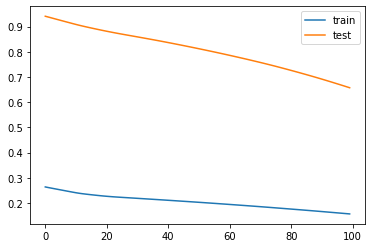

Train on 81 samples, validate on 21 samples
Epoch 1/100
 - 1s - loss: 0.3230 - val_loss: 0.6865
Epoch 2/100
 - 0s - loss: 0.3117 - val_loss: 0.6693
Epoch 3/100
 - 0s - loss: 0.3009 - val_loss: 0.6529
Epoch 4/100
 - 0s - loss: 0.2901 - val_loss: 0.6360
Epoch 5/100
 - 0s - loss: 0.2791 - val_loss: 0.6184
Epoch 6/100
 - 0s - loss: 0.2682 - val_loss: 0.6003
Epoch 7/100
 - 0s - loss: 0.2570 - val_loss: 0.5817
Epoch 8/100
 - 0s - loss: 0.2458 - val_loss: 0.5629
Epoch 9/100
 - 0s - loss: 0.2348 - val_loss: 0.5429
Epoch 10/100
 - 0s - loss: 0.2247 - val_loss: 0.5238
Epoch 11/100
 - 0s - loss: 0.2167 - val_loss: 0.5046
Epoch 12/100
 - 0s - loss: 0.2098 - val_loss: 0.4865
Epoch 13/100
 - 0s - loss: 0.2028 - val_loss: 0.4675
Epoch 14/100
 - 0s - loss: 0.1963 - val_loss: 0.4499
Epoch 15/100
 - 0s - loss: 0.1906 - val_loss: 0.4351
Epoch 16/100
 - 0s - loss: 0.1849 - val_loss: 0.4210
Epoch 17/100
 - 0s - loss: 0.1795 - val_loss: 0.4080
Epoch 18/100
 - 0s - loss: 0.1741 - val_loss: 0.3949
Epoch 19/10

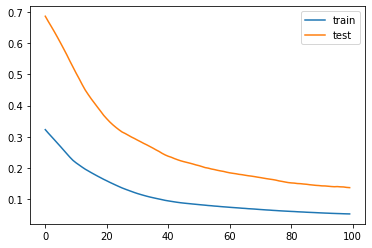

Train on 81 samples, validate on 21 samples
Epoch 1/100
 - 1s - loss: 0.3703 - val_loss: 0.7666
Epoch 2/100
 - 0s - loss: 0.3653 - val_loss: 0.7604
Epoch 3/100
 - 0s - loss: 0.3606 - val_loss: 0.7541
Epoch 4/100
 - 0s - loss: 0.3559 - val_loss: 0.7478
Epoch 5/100
 - 0s - loss: 0.3512 - val_loss: 0.7416
Epoch 6/100
 - 0s - loss: 0.3465 - val_loss: 0.7353
Epoch 7/100
 - 0s - loss: 0.3418 - val_loss: 0.7291
Epoch 8/100
 - 0s - loss: 0.3379 - val_loss: 0.7235
Epoch 9/100
 - 0s - loss: 0.3344 - val_loss: 0.7181
Epoch 10/100
 - 0s - loss: 0.3310 - val_loss: 0.7128
Epoch 11/100
 - 0s - loss: 0.3276 - val_loss: 0.7074
Epoch 12/100
 - 0s - loss: 0.3242 - val_loss: 0.7021
Epoch 13/100
 - 0s - loss: 0.3209 - val_loss: 0.6967
Epoch 14/100
 - 0s - loss: 0.3178 - val_loss: 0.6915
Epoch 15/100
 - 0s - loss: 0.3147 - val_loss: 0.6863
Epoch 16/100
 - 0s - loss: 0.3117 - val_loss: 0.6812
Epoch 17/100
 - 0s - loss: 0.3088 - val_loss: 0.6761
Epoch 18/100
 - 0s - loss: 0.3060 - val_loss: 0.6711
Epoch 19/10

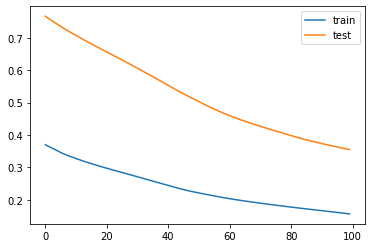

Train on 81 samples, validate on 21 samples
Epoch 1/100
 - 1s - loss: 0.3350 - val_loss: 0.7491
Epoch 2/100
 - 0s - loss: 0.3333 - val_loss: 0.7472
Epoch 3/100
 - 0s - loss: 0.3317 - val_loss: 0.7453
Epoch 4/100
 - 0s - loss: 0.3302 - val_loss: 0.7434
Epoch 5/100
 - 0s - loss: 0.3287 - val_loss: 0.7416
Epoch 6/100
 - 0s - loss: 0.3272 - val_loss: 0.7397
Epoch 7/100
 - 0s - loss: 0.3257 - val_loss: 0.7379
Epoch 8/100
 - 0s - loss: 0.3242 - val_loss: 0.7361
Epoch 9/100
 - 0s - loss: 0.3228 - val_loss: 0.7343
Epoch 10/100
 - 0s - loss: 0.3213 - val_loss: 0.7325
Epoch 11/100
 - 0s - loss: 0.3199 - val_loss: 0.7307
Epoch 12/100
 - 0s - loss: 0.3184 - val_loss: 0.7288
Epoch 13/100
 - 0s - loss: 0.3169 - val_loss: 0.7270
Epoch 14/100
 - 0s - loss: 0.3155 - val_loss: 0.7252
Epoch 15/100
 - 0s - loss: 0.3140 - val_loss: 0.7234
Epoch 16/100
 - 0s - loss: 0.3126 - val_loss: 0.7216
Epoch 17/100
 - 0s - loss: 0.3112 - val_loss: 0.7198
Epoch 18/100
 - 0s - loss: 0.3098 - val_loss: 0.7180
Epoch 19/10

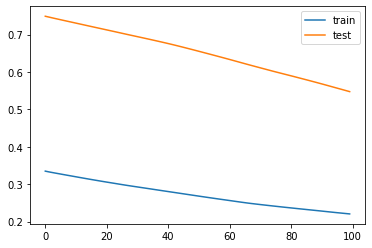

Train on 80 samples, validate on 21 samples
Epoch 1/100
 - 1s - loss: 0.2138 - val_loss: 0.8356
Epoch 2/100
 - 0s - loss: 0.1987 - val_loss: 0.8155
Epoch 3/100
 - 0s - loss: 0.1884 - val_loss: 0.8033
Epoch 4/100
 - 0s - loss: 0.1811 - val_loss: 0.7930
Epoch 5/100
 - 0s - loss: 0.1758 - val_loss: 0.7869
Epoch 6/100
 - 0s - loss: 0.1709 - val_loss: 0.7807
Epoch 7/100
 - 0s - loss: 0.1663 - val_loss: 0.7709
Epoch 8/100
 - 0s - loss: 0.1630 - val_loss: 0.7603
Epoch 9/100
 - 0s - loss: 0.1597 - val_loss: 0.7490
Epoch 10/100
 - 0s - loss: 0.1565 - val_loss: 0.7375
Epoch 11/100
 - 0s - loss: 0.1532 - val_loss: 0.7252
Epoch 12/100
 - 0s - loss: 0.1501 - val_loss: 0.7132
Epoch 13/100
 - 0s - loss: 0.1467 - val_loss: 0.7002
Epoch 14/100
 - 0s - loss: 0.1433 - val_loss: 0.6865
Epoch 15/100
 - 0s - loss: 0.1401 - val_loss: 0.6735
Epoch 16/100
 - 0s - loss: 0.1365 - val_loss: 0.6583
Epoch 17/100
 - 0s - loss: 0.1331 - val_loss: 0.6435
Epoch 18/100
 - 0s - loss: 0.1294 - val_loss: 0.6279
Epoch 19/10

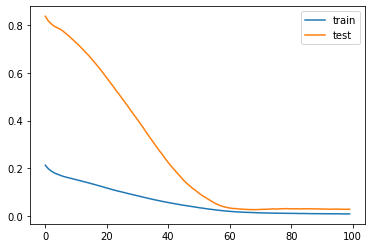

Train on 80 samples, validate on 21 samples
Epoch 1/100
 - 1s - loss: 0.2087 - val_loss: 0.8473
Epoch 2/100
 - 0s - loss: 0.2059 - val_loss: 0.8447
Epoch 3/100
 - 0s - loss: 0.2034 - val_loss: 0.8421
Epoch 4/100
 - 0s - loss: 0.2010 - val_loss: 0.8394
Epoch 5/100
 - 0s - loss: 0.1989 - val_loss: 0.8372
Epoch 6/100
 - 0s - loss: 0.1973 - val_loss: 0.8352
Epoch 7/100
 - 0s - loss: 0.1959 - val_loss: 0.8334
Epoch 8/100
 - 0s - loss: 0.1945 - val_loss: 0.8318
Epoch 9/100
 - 0s - loss: 0.1932 - val_loss: 0.8304
Epoch 10/100
 - 0s - loss: 0.1920 - val_loss: 0.8289
Epoch 11/100
 - 0s - loss: 0.1908 - val_loss: 0.8275
Epoch 12/100
 - 0s - loss: 0.1896 - val_loss: 0.8261
Epoch 13/100
 - 0s - loss: 0.1884 - val_loss: 0.8247
Epoch 14/100
 - 0s - loss: 0.1872 - val_loss: 0.8234
Epoch 15/100
 - 0s - loss: 0.1860 - val_loss: 0.8220
Epoch 16/100
 - 0s - loss: 0.1849 - val_loss: 0.8206
Epoch 17/100
 - 0s - loss: 0.1837 - val_loss: 0.8191
Epoch 18/100
 - 0s - loss: 0.1825 - val_loss: 0.8177
Epoch 19/10

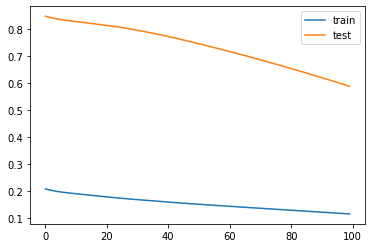

Train on 80 samples, validate on 21 samples
Epoch 1/100
 - 1s - loss: 0.2127 - val_loss: 0.8940
Epoch 2/100
 - 0s - loss: 0.2112 - val_loss: 0.8919
Epoch 3/100
 - 0s - loss: 0.2099 - val_loss: 0.8900
Epoch 4/100
 - 0s - loss: 0.2087 - val_loss: 0.8882
Epoch 5/100
 - 0s - loss: 0.2075 - val_loss: 0.8864
Epoch 6/100
 - 0s - loss: 0.2064 - val_loss: 0.8847
Epoch 7/100
 - 0s - loss: 0.2052 - val_loss: 0.8830
Epoch 8/100
 - 0s - loss: 0.2041 - val_loss: 0.8814
Epoch 9/100
 - 0s - loss: 0.2031 - val_loss: 0.8799
Epoch 10/100
 - 0s - loss: 0.2020 - val_loss: 0.8783
Epoch 11/100
 - 0s - loss: 0.2009 - val_loss: 0.8768
Epoch 12/100
 - 0s - loss: 0.1998 - val_loss: 0.8753
Epoch 13/100
 - 0s - loss: 0.1989 - val_loss: 0.8740
Epoch 14/100
 - 0s - loss: 0.1981 - val_loss: 0.8727
Epoch 15/100
 - 0s - loss: 0.1973 - val_loss: 0.8714
Epoch 16/100
 - 0s - loss: 0.1967 - val_loss: 0.8703
Epoch 17/100
 - 0s - loss: 0.1962 - val_loss: 0.8694
Epoch 18/100
 - 0s - loss: 0.1958 - val_loss: 0.8685
Epoch 19/10

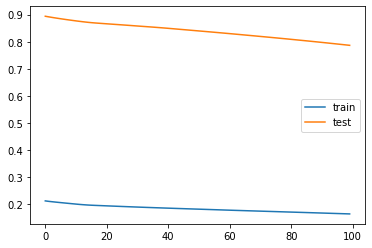

Train on 80 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2056 - val_loss: 0.8449
Epoch 2/100
 - 0s - loss: 0.1953 - val_loss: 0.8292
Epoch 3/100
 - 0s - loss: 0.1913 - val_loss: 0.8191
Epoch 4/100
 - 0s - loss: 0.1863 - val_loss: 0.8095
Epoch 5/100
 - 0s - loss: 0.1814 - val_loss: 0.7996
Epoch 6/100
 - 0s - loss: 0.1762 - val_loss: 0.7889
Epoch 7/100
 - 0s - loss: 0.1710 - val_loss: 0.7763
Epoch 8/100
 - 0s - loss: 0.1667 - val_loss: 0.7639
Epoch 9/100
 - 0s - loss: 0.1623 - val_loss: 0.7495
Epoch 10/100
 - 0s - loss: 0.1580 - val_loss: 0.7353
Epoch 11/100
 - 0s - loss: 0.1539 - val_loss: 0.7205
Epoch 12/100
 - 0s - loss: 0.1502 - val_loss: 0.7059
Epoch 13/100
 - 0s - loss: 0.1464 - val_loss: 0.6903
Epoch 14/100
 - 0s - loss: 0.1429 - val_loss: 0.6751
Epoch 15/100
 - 0s - loss: 0.1390 - val_loss: 0.6582
Epoch 16/100
 - 0s - loss: 0.1354 - val_loss: 0.6420
Epoch 17/100
 - 0s - loss: 0.1313 - val_loss: 0.6236
Epoch 18/100
 - 0s - loss: 0.1277 - val_loss: 0.6067
Epoch 19/10

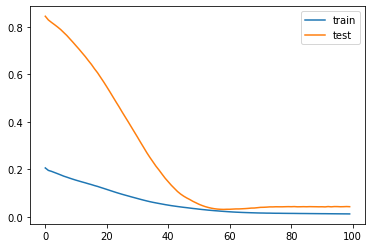

Train on 80 samples, validate on 20 samples
Epoch 1/100
 - 0s - loss: 0.2384 - val_loss: 0.9152
Epoch 2/100
 - 0s - loss: 0.2349 - val_loss: 0.9109
Epoch 3/100
 - 0s - loss: 0.2318 - val_loss: 0.9068
Epoch 4/100
 - 0s - loss: 0.2289 - val_loss: 0.9030
Epoch 5/100
 - 0s - loss: 0.2264 - val_loss: 0.8996
Epoch 6/100
 - 0s - loss: 0.2241 - val_loss: 0.8963
Epoch 7/100
 - 0s - loss: 0.2218 - val_loss: 0.8931
Epoch 8/100
 - 0s - loss: 0.2196 - val_loss: 0.8899
Epoch 9/100
 - 0s - loss: 0.2173 - val_loss: 0.8868
Epoch 10/100
 - 0s - loss: 0.2151 - val_loss: 0.8837
Epoch 11/100
 - 0s - loss: 0.2130 - val_loss: 0.8809
Epoch 12/100
 - 0s - loss: 0.2115 - val_loss: 0.8785
Epoch 13/100
 - 0s - loss: 0.2105 - val_loss: 0.8764
Epoch 14/100
 - 0s - loss: 0.2096 - val_loss: 0.8746
Epoch 15/100
 - 0s - loss: 0.2086 - val_loss: 0.8729
Epoch 16/100
 - 0s - loss: 0.2076 - val_loss: 0.8711
Epoch 17/100
 - 0s - loss: 0.2067 - val_loss: 0.8693
Epoch 18/100
 - 0s - loss: 0.2058 - val_loss: 0.8677
Epoch 19/10

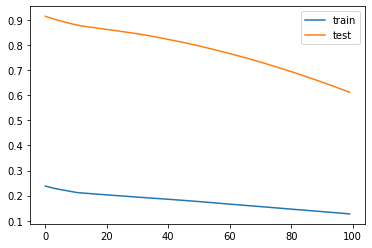

Train on 80 samples, validate on 20 samples
Epoch 1/100
 - 0s - loss: 0.2410 - val_loss: 0.9228
Epoch 2/100
 - 0s - loss: 0.2390 - val_loss: 0.9203
Epoch 3/100
 - 0s - loss: 0.2371 - val_loss: 0.9178
Epoch 4/100
 - 0s - loss: 0.2352 - val_loss: 0.9153
Epoch 5/100
 - 0s - loss: 0.2333 - val_loss: 0.9128
Epoch 6/100
 - 0s - loss: 0.2315 - val_loss: 0.9103
Epoch 7/100
 - 0s - loss: 0.2296 - val_loss: 0.9078
Epoch 8/100
 - 0s - loss: 0.2277 - val_loss: 0.9053
Epoch 9/100
 - 0s - loss: 0.2258 - val_loss: 0.9028
Epoch 10/100
 - 0s - loss: 0.2240 - val_loss: 0.9003
Epoch 11/100
 - 0s - loss: 0.2221 - val_loss: 0.8978
Epoch 12/100
 - 0s - loss: 0.2202 - val_loss: 0.8952
Epoch 13/100
 - 0s - loss: 0.2184 - val_loss: 0.8927
Epoch 14/100
 - 0s - loss: 0.2165 - val_loss: 0.8902
Epoch 15/100
 - 0s - loss: 0.2147 - val_loss: 0.8877
Epoch 16/100
 - 0s - loss: 0.2129 - val_loss: 0.8853
Epoch 17/100
 - 0s - loss: 0.2115 - val_loss: 0.8831
Epoch 18/100
 - 0s - loss: 0.2103 - val_loss: 0.8811
Epoch 19/10

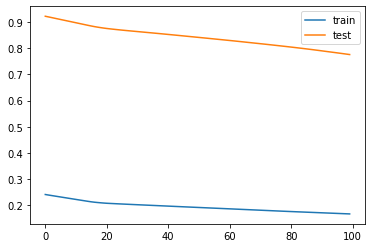

Train on 76 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2158 - val_loss: 0.8498
Epoch 2/100
 - 0s - loss: 0.2053 - val_loss: 0.8298
Epoch 3/100
 - 0s - loss: 0.2006 - val_loss: 0.8151
Epoch 4/100
 - 0s - loss: 0.1954 - val_loss: 0.7997
Epoch 5/100
 - 0s - loss: 0.1906 - val_loss: 0.7842
Epoch 6/100
 - 0s - loss: 0.1852 - val_loss: 0.7673
Epoch 7/100
 - 0s - loss: 0.1797 - val_loss: 0.7492
Epoch 8/100
 - 0s - loss: 0.1738 - val_loss: 0.7298
Epoch 9/100
 - 0s - loss: 0.1677 - val_loss: 0.7088
Epoch 10/100
 - 0s - loss: 0.1614 - val_loss: 0.6867
Epoch 11/100
 - 0s - loss: 0.1548 - val_loss: 0.6626
Epoch 12/100
 - 0s - loss: 0.1479 - val_loss: 0.6367
Epoch 13/100
 - 0s - loss: 0.1407 - val_loss: 0.6087
Epoch 14/100
 - 0s - loss: 0.1331 - val_loss: 0.5787
Epoch 15/100
 - 0s - loss: 0.1256 - val_loss: 0.5472
Epoch 16/100
 - 0s - loss: 0.1181 - val_loss: 0.5139
Epoch 17/100
 - 0s - loss: 0.1104 - val_loss: 0.4782
Epoch 18/100
 - 0s - loss: 0.1031 - val_loss: 0.4424
Epoch 19/10

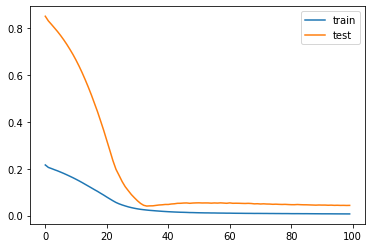

Train on 76 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2322 - val_loss: 0.8885
Epoch 2/100
 - 0s - loss: 0.2291 - val_loss: 0.8843
Epoch 3/100
 - 0s - loss: 0.2264 - val_loss: 0.8801
Epoch 4/100
 - 0s - loss: 0.2237 - val_loss: 0.8758
Epoch 5/100
 - 0s - loss: 0.2210 - val_loss: 0.8716
Epoch 6/100
 - 0s - loss: 0.2184 - val_loss: 0.8674
Epoch 7/100
 - 0s - loss: 0.2157 - val_loss: 0.8632
Epoch 8/100
 - 0s - loss: 0.2134 - val_loss: 0.8594
Epoch 9/100
 - 0s - loss: 0.2118 - val_loss: 0.8561
Epoch 10/100
 - 0s - loss: 0.2104 - val_loss: 0.8530
Epoch 11/100
 - 0s - loss: 0.2090 - val_loss: 0.8500
Epoch 12/100
 - 0s - loss: 0.2076 - val_loss: 0.8469
Epoch 13/100
 - 0s - loss: 0.2062 - val_loss: 0.8438
Epoch 14/100
 - 0s - loss: 0.2049 - val_loss: 0.8407
Epoch 15/100
 - 0s - loss: 0.2035 - val_loss: 0.8375
Epoch 16/100
 - 0s - loss: 0.2021 - val_loss: 0.8343
Epoch 17/100
 - 0s - loss: 0.2007 - val_loss: 0.8310
Epoch 18/100
 - 0s - loss: 0.1994 - val_loss: 0.8278
Epoch 19/10

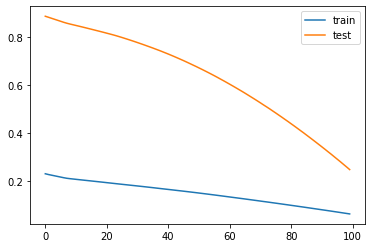

Train on 76 samples, validate on 20 samples
Epoch 1/100
 - 1s - loss: 0.2427 - val_loss: 0.9219
Epoch 2/100
 - 0s - loss: 0.2405 - val_loss: 0.9184
Epoch 3/100
 - 0s - loss: 0.2383 - val_loss: 0.9150
Epoch 4/100
 - 0s - loss: 0.2363 - val_loss: 0.9116
Epoch 5/100
 - 0s - loss: 0.2343 - val_loss: 0.9083
Epoch 6/100
 - 0s - loss: 0.2324 - val_loss: 0.9050
Epoch 7/100
 - 0s - loss: 0.2306 - val_loss: 0.9018
Epoch 8/100
 - 0s - loss: 0.2288 - val_loss: 0.8986
Epoch 9/100
 - 0s - loss: 0.2271 - val_loss: 0.8955
Epoch 10/100
 - 0s - loss: 0.2255 - val_loss: 0.8925
Epoch 11/100
 - 0s - loss: 0.2239 - val_loss: 0.8895
Epoch 12/100
 - 0s - loss: 0.2225 - val_loss: 0.8866
Epoch 13/100
 - 0s - loss: 0.2212 - val_loss: 0.8837
Epoch 14/100
 - 0s - loss: 0.2199 - val_loss: 0.8810
Epoch 15/100
 - 0s - loss: 0.2187 - val_loss: 0.8783
Epoch 16/100
 - 0s - loss: 0.2175 - val_loss: 0.8756
Epoch 17/100
 - 0s - loss: 0.2163 - val_loss: 0.8729
Epoch 18/100
 - 0s - loss: 0.2150 - val_loss: 0.8702
Epoch 19/10

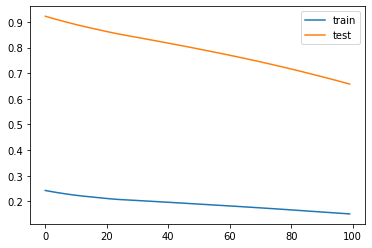

In [117]:
test = dataset
agg_d, nf = aggregate_data(test)

rmse_vals = dict()
for i, config in enumerate(model_configs()):
    sliding_window = series_to_supervised(agg_d, config[0], config[1])
    drop = [col for col in sliding_window.columns if '-' not in col and 'var1' not in col and 'var2' not in col]
    sliding_window.drop(drop, axis=1, inplace=True)
    values = sliding_window.values
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0,1))
    scaled_d = scaler.fit_transform(values)
    X_train, y_train, X_test, y_test = split_data(scaled_d, 2)
    model = build_model(X_train, y_train, X_test, y_test, config[2])
    inv_yhat, inv_y, rmse = evaluate(model, X_test, y_test, nf, scaler)
    rmse_vals[i] = rmse

In [125]:
sorted(rmse_vals.items(), key=lambda x: x[1])

[(15, 17010.534390932055),
 (0, 18047.165204512276),
 (12, 19982.190155648655),
 (33, 22359.346935453876),
 (18, 25794.612751580193),
 (3, 29514.89815988364),
 (27, 31357.907962076944),
 (6, 34446.82261458223),
 (13, 34680.25691603232),
 (21, 35046.821801385144),
 (1, 36288.068018057354),
 (9, 36790.24414219433),
 (24, 41718.29057929965),
 (51, 41739.424871588424),
 (48, 42115.357751100375),
 (16, 43501.675956446656),
 (5, 44363.32056899211),
 (57, 44691.09660911784),
 (4, 46113.810362059834),
 (42, 48474.106833034195),
 (36, 48783.07286077912),
 (45, 49381.788586573624),
 (10, 52102.72232040473),
 (39, 56195.13010334795),
 (7, 57127.75417897582),
 (34, 58137.83455865115),
 (19, 60208.27966266712),
 (54, 62969.41967328792),
 (30, 63946.32269765762),
 (11, 78175.69649401936),
 (22, 86616.52740523849),
 (25, 127351.17101224913),
 (20, 141402.82980818316),
 (31, 143912.1929477997),
 (8, 154479.64274709355),
 (58, 208858.08600497915),
 (2, 236101.15843161894),
 (23, 291212.9683935314),
 (4

In [128]:
configs = model_configs()

60


In [129]:
configs[15]

[14, 2, 1]

In [131]:
configs[0]

[21, 1, 1]

In [132]:
configs[12]

[14, 1, 1]

In [133]:
configs[33]

[7, 7, 1]

In [134]:
configs[18]

[14, 3, 1]

In [202]:
values.shape

(90, 130)

In [209]:
X_test.shape

(18, 1, 126)

In [204]:
y_test.shape

(18, 4)

In [227]:
X_test_reshape = X_test.reshape(X_test.shape[0], X_test.shape[2])
combines = np.concatenate((y_test, X_test_reshape[:, :]), axis=1)

In [228]:
combines.shape

(18, 130)

In [217]:
X_test.shape[2]

126

In [218]:
y_test.shape

(18, 4)

In [7]:
dataset = pd.read_csv("../data/cleaned_data/dataset_3.csv", index_col=0).dropna()
# dataset.sort_values(by="date", inplace=True)

In [187]:
sliding_window

,var1(t-14),var2(t-14),var3(t-14),var4(t-14),var5(t-14),var6(t-14),var7(t-14),var8(t-14),var9(t-14),var1(t-13),...,var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t),var2(t),var1(t+1),var2(t+1)
14,13.0,1.0,4.218968,0.928323,12.906456,3.066183,0.343089,-0.447505,136.245536,13.0,...,4.075054,10.794182,5.360737,2.121792,-0.919642,142.832488,34.0,3.0,40.0,3.0
15,13.0,1.0,6.967964,0.906705,17.142396,1.923964,0.222874,-0.735286,105.098096,13.0,...,6.196566,20.723547,6.862814,3.245117,-1.729281,141.963185,40.0,3.0,62.0,8.0
16,13.0,2.0,7.210259,0.252258,27.445434,-4.414065,-23.941719,5.176728,113.950923,14.0,...,8.487996,26.539330,6.952990,2.909019,-1.272723,104.390988,62.0,8.0,81.0,9.0
17,14.0,2.0,0.060175,-1.273332,5.262097,2.012103,-0.856775,0.757630,110.424471,14.0,...,5.720256,12.166232,1.965241,3.282232,-0.533354,109.474354,81.0,9.0,116.0,13.0
18,14.0,2.0,1.830238,0.098087,7.895023,2.143494,0.170304,0.264522,111.814184,14.0,...,9.352538,20.183928,3.171989,1.746740,-0.649461,114.294205,116.0,13.0,182.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,1280670.0,76383.0,-30.339448,0.820605,18.081268,-29.391754,-27.535630,7.033047,76.198520,1302500.0,...,-0.624497,37.567317,-23.064800,-22.100930,7.522328,127.654568,1578380.0,94298.0,1601571.0,95087.0
100,1302500.0,77498.0,-31.190460,-11.114066,2.713908,-33.124112,-42.739941,16.414086,84.278602,1323359.0,...,-2.101131,56.755025,-26.220847,-24.572505,5.507191,106.354675,1601571.0,95087.0,1618800.0,95727.0
101,1323359.0,79093.0,-28.666133,-5.900632,18.414912,-30.740833,-43.216488,16.797147,91.774952,1343399.0,...,-7.858629,55.610162,-38.648373,-72.046274,20.555805,103.674950,1618800.0,95727.0,1636760.0,97070.0
102,1343399.0,80825.0,-26.928263,-4.817347,28.080448,-29.784904,-43.141199,16.557801,99.269055,1368703.0,...,-3.005928,34.461128,-27.221979,-39.822021,14.277307,116.742536,1636760.0,97070.0,1658657.0,98212.0


In [19]:
yhat = model.predict(X_test)
X_test_reshape = X_test.reshape(X_test.shape[0], X_test.shape[2])
inv_yhat = np.concatenate((yhat, X_test_reshape[:, 2:(n_feats)]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,:2]
y_test_reshaped = y_test.reshape((len(y_test), 2))
inv_y = np.concatenate((y_test_reshaped, X_test_reshape[:, 2:(n_feats)]), axis=1)
full = scaler.inverse_transform(inv_y)
inv_y = full[:,:2]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'n_feats' is not defined

In [49]:
agg_d[72:]

,cases,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,mobility_from_baseline
72,958005.0,52319.0,-35.577854,-13.278853,1.927514,-37.159192,-46.722990,18.438683,74.922028
73,981795.0,54445.0,-34.707172,-10.392662,15.000078,-34.690515,-48.217848,12.808646,77.722858
74,1008967.0,57330.0,-34.828685,-10.732236,0.176238,-35.614098,-48.401069,19.293063,78.052014
75,1037005.0,59410.0,-34.938330,-9.400308,-4.085414,-36.299683,-48.386406,19.708136,81.665392
76,1068478.0,61232.0,-33.377955,-6.006160,14.246999,-33.401572,-46.246007,19.008022,96.621498
77,1095539.0,62897.0,-35.893997,-4.901810,35.324036,-27.393267,-29.924671,10.325207,92.231414
78,1118735.0,64093.0,-33.842681,-8.316686,35.364381,-31.744961,-31.233969,8.791095,74.567874
79,1141778.0,65150.0,-28.951480,-7.629869,12.929797,-33.549065,-44.324220,16.472365,85.025598
80,1164484.0,67575.0,-28.202098,-2.893997,12.610040,-32.287534,-45.364730,17.436704,87.246110
81,1188021.0,70310.0,-30.158951,-5.629559,13.429389,-32.054938,-45.453215,17.641283,88.682657


In [90]:
dates = agg_d[86:][["cases", "deaths"]].reset_index()

In [91]:
inv_y_df = pd.DataFrame(inv_y)
inv_y.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [92]:
inv_yhat_df = pd.DataFrame(inv_yhat)
inv_yhat_df

,0,1,2,3
0,1.253986e+06,77667.904063,1.290085e+06,79581.356792
1,1.321878e+06,80221.498361,1.291302e+06,78592.457047
2,1.430871e+06,84110.734254,1.400413e+06,84193.692131
3,1.391662e+06,83330.820715,1.423418e+06,89726.079839
4,1.396645e+06,86282.028438,1.436808e+06,88751.726400
5,1.425680e+06,89049.581784,1.459587e+06,86772.337669
6,1.459576e+06,89321.205754,1.458283e+06,91741.457779
7,1.461130e+06,91513.661110,1.482726e+06,95471.372570
8,1.493263e+06,93595.071538,1.506336e+06,95485.752836
9,1.524525e+06,96050.048341,1.587086e+06,99637.059819


In [95]:
results = pd.DataFrame()
results = pd.concat([dates.drop(["cases", "deaths"], axis=1), inv_y_df, inv_yhat_df], axis=1)
results.tail()

,index,0,1,2,3,0,1,2,3
14,100,1601571.0,95087.0,1618800.0,95727.0,1.639311e+06,103641.833525,1.616624e+06,105317.970470
15,101,1618800.0,95727.0,1636760.0,97070.0,1.679845e+06,104399.631738,1.681854e+06,108357.063223
16,102,1636760.0,97070.0,1658657.0,98212.0,1.720094e+06,106710.419893,1.744288e+06,111938.715992
17,103,1658657.0,98212.0,1682547.0,99492.0,1.720836e+06,107717.820409,1.708112e+06,112743.915995
18,104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
sliding_window.iloc[[72,  ]]

,var1(t-14),var2(t-14),var3(t-14),var4(t-14),var5(t-14),var6(t-14),var7(t-14),var8(t-14),var9(t-14),var1(t-13),...,var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var1(t),var2(t),var1(t+1),var2(t+1)
86,958005.0,52319.0,-35.577854,-13.278853,1.927514,-37.159192,-46.72299,18.438683,74.922028,981795.0,...,0.820605,18.081268,-29.391754,-27.53563,7.033047,76.19852,1302500.0,77498.0,1323359.0,79093.0


In [96]:
results.columns = ["date", "cases", "deaths", "cases_2", "deaths_2", "cases_hat", "deaths_hat", "cases_hat_2", "deaths_hat_2"]

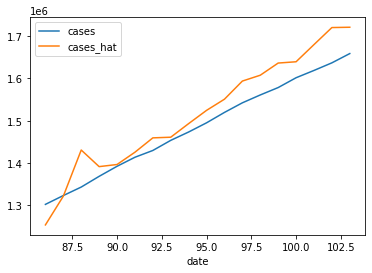

In [97]:
results.plot(x="date", y=["cases", "cases_hat"])

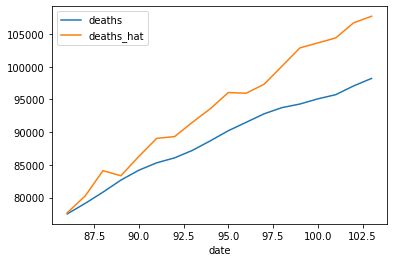

In [98]:
results.plot(x="date", y=["deaths", "deaths_hat"])

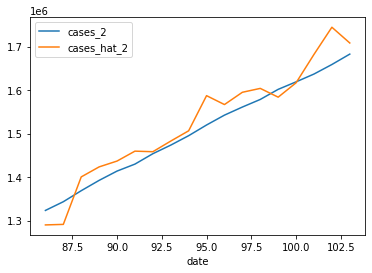

In [99]:
results.plot(x="date", y=["cases_2", "cases_hat_2"])

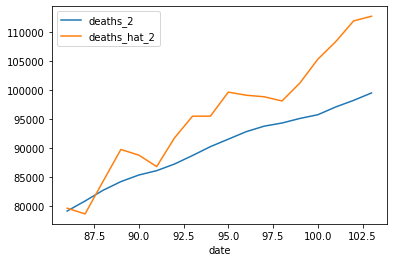

In [100]:
results.plot(x="date", y=["deaths_2", "deaths_hat_2"])